In [ ]:
# 1. 数据预处理和基本统计分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import warnings

# 忽略警告信息，避免运行时出现大量警告干扰
warnings.filterwarnings('ignore')

# 设置可视化风格和字体配置，确保中文显示正常
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 8)  # 设置默认图表大小
plt.rcParams['axes.labelsize'] = 12  # 轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 图表标题字体大小
plt.rcParams['xtick.labelsize'] = 10  # X轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 10  # Y轴刻度标签大小

# 定义列名映射字典，将英文列名转换为中文
column_mapping = {
    'Date': '日期',
    'Close': '收盘',
    'Open': '开盘',
    'High': '高',
    'Low': '低',
    'Volume': '交易量',
    'Change': '涨跌幅'
}

def preprocess_data(data):
    """数据预处理函数，包括列名转换、数据类型转换和缺失值处理"""
    # 重命名列
    data.columns = data.columns.str.strip()  # 去除列名前后空格
    data = data.rename(columns=column_mapping)
    
    # 转换日期格式为 datetime 类型
    data['日期'] = pd.to_datetime(data['日期'], errors='coerce')
    
    # 将价格列转换为数值类型，去除可能存在的逗号分隔符
    for col in ['收盘', '开盘', '高', '低']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')
    
    # 处理交易量格式 (如 "914.76K" 转换为 914760)
    if '交易量' in data.columns:
        def convert_volume(x):
            if isinstance(x, str):
                if 'K' in x:
                    return float(x.replace('K', '')) * 1000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                else:
                    return float(x)
            return x
        
        data['交易量'] = data['交易量'].apply(convert_volume)
    
    # 处理涨跌幅，转换为小数形式
    if '涨跌幅' in data.columns:
        data['涨跌幅'] = data['涨跌幅'].str.replace('%', '').astype(float) / 100
    
    # 按日期排序并设置为索引
    data = data.sort_values('日期').set_index('日期')
    
    # 填充缺失值，使用前向填充和后向填充
    data = data.ffill().bfill()
    
    # 添加技术指标：均线和收益率
    if '收盘' in data.columns:
        data['5日均线'] = data['收盘'].rolling(window=5).mean()
        data['20日均线'] = data['收盘'].rolling(window=20).mean()
        data['50日均线'] = data['收盘'].rolling(window=50).mean()
        data['日收益率'] = data['收盘'].pct_change()
        data['波动率'] = data['日收益率'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    
    return data  # 返回预处理后的数据

def analyze_data(file_path):
    """主分析函数，协调调用各个分析模块"""
    # 加载数据
    data = pd.read_csv(file_path)
    
    # 获取文件名作为标题
    title = file_path.split('/')[-1].split('.')[0]
    print(f"\n{'='*50}")
    print(f"开始分析: {title}")
    print(f"{'='*50}")
    
    # 数据预处理
    data = preprocess_data(data)
    
    # 输出基本统计信息
    print(f"\n{title} - 基本统计信息:")
    print(data.describe())

    # 这里可以继续调用其他分析模块
    # plot_price_volume(data, title)
    # plot_correlation_heatmap(data, title)
    # plot_rolling_correlation(data, title)
    # plot_volatility(data, title)
    # plot_return_distribution(data, title)
    # plot_seasonality(data, title)
    # plot_autocorrelation(data, title)
    # garch_model_analysis(data, title)
    # granger_causality_analysis(data, title)
    # cointegration_analysis(data, title)
    # var_model_analysis(data, title)
    
    print(f"\n{'='*50}")
    print(f"完成分析: {title}")
    print(f"{'='*50}")

# 定义文件路径列表
file_paths = [
    'C:/Users/Lenovo/Desktop/以太坊历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/比特币历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/BTC_EUR Kraken 历史数据.csv',
    'C:/Users/Lenovo/Desktop/ETH_EUR Kraken 历史数据.csv'
]

# 对每份数据进行分析
for file_path in file_paths:
    try:
        analyze_data(file_path)
    except Exception as e:
        print(f"分析 {file_path} 时出错: {str(e)}")


开始分析: 以太坊历史数据USD

以太坊历史数据USD - 基本统计信息:
                收盘           开盘            高            低           交易量  \
count  1967.000000  1967.000000  1967.000000  1967.000000  1.967000e+03   
mean   2011.848399  2010.615425  2066.220946  1949.762999  1.259726e+07   
std    1123.526370  1124.245026  1154.086936  1089.428287  1.109803e+08   
min     107.900000   107.870000   117.910000    88.500000  2.703000e+04   
25%    1302.855000  1299.485000  1338.780000  1264.220000  3.799450e+05   
50%    1890.040000  1889.870000  1931.060000  1852.420000  6.732100e+05   
75%    2889.210000  2889.295000  2963.620000  2776.115000  1.895000e+06   
max    4808.380000  4808.340000  4864.060000  4715.430000  1.790000e+09   

               涨跌幅         5日均线        20日均线        50日均线         日收益率  \
count  1967.000000  1963.000000  1948.000000  1918.000000  1966.000000   
mean      0.002511  2013.236172  2018.866531  2034.448813     0.002506   
std       0.044118  1119.933514  1108.131009  1085.143441     

In [ ]:
# 2. 可视化分析

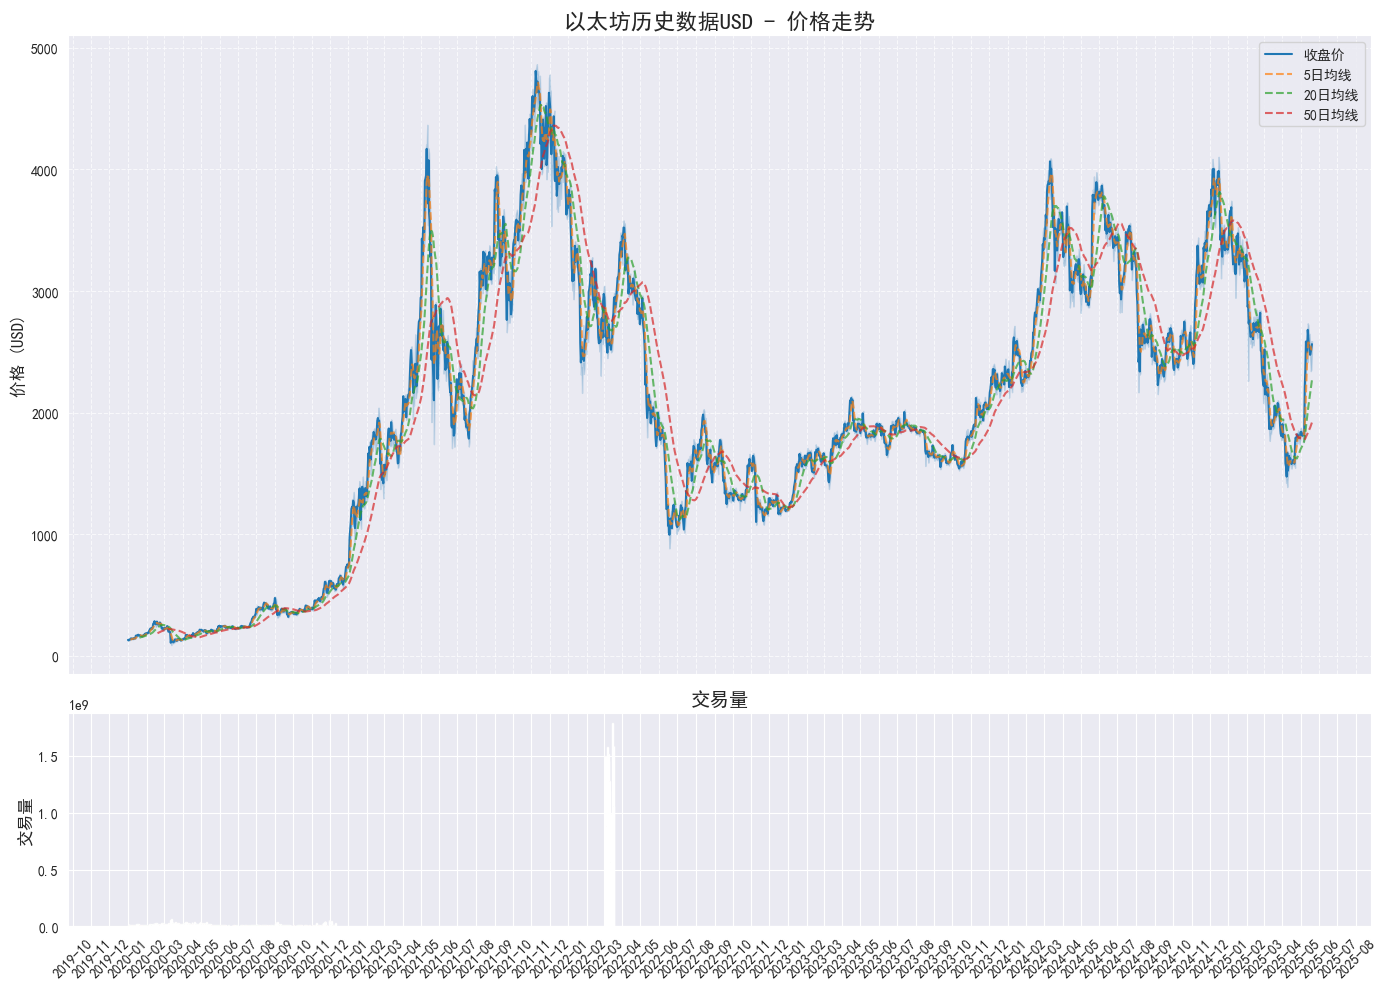

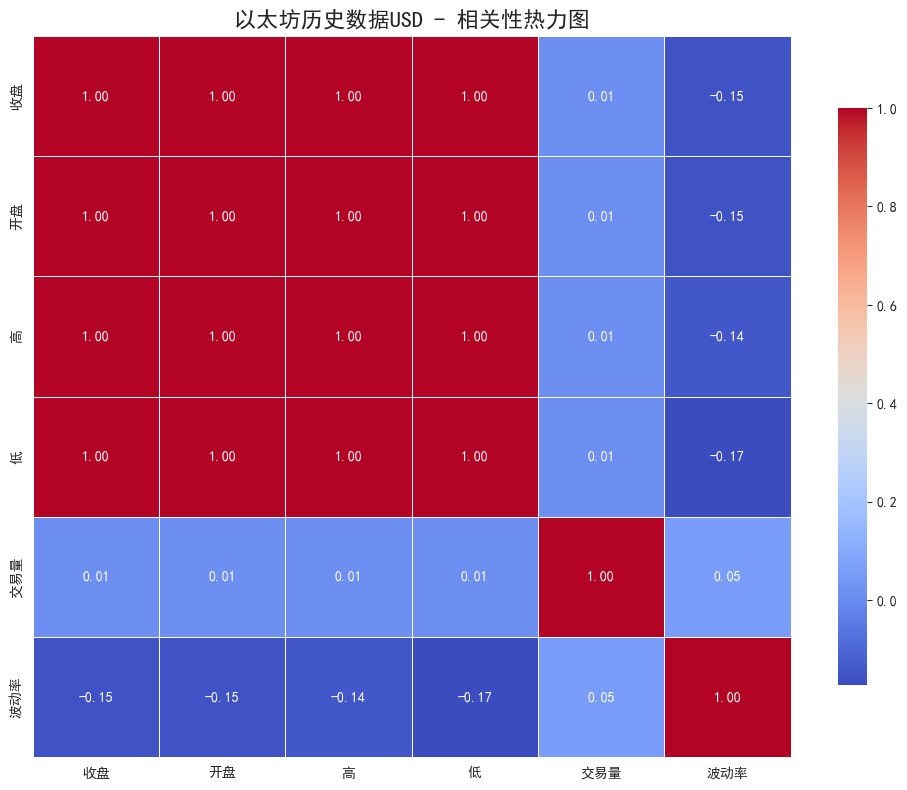

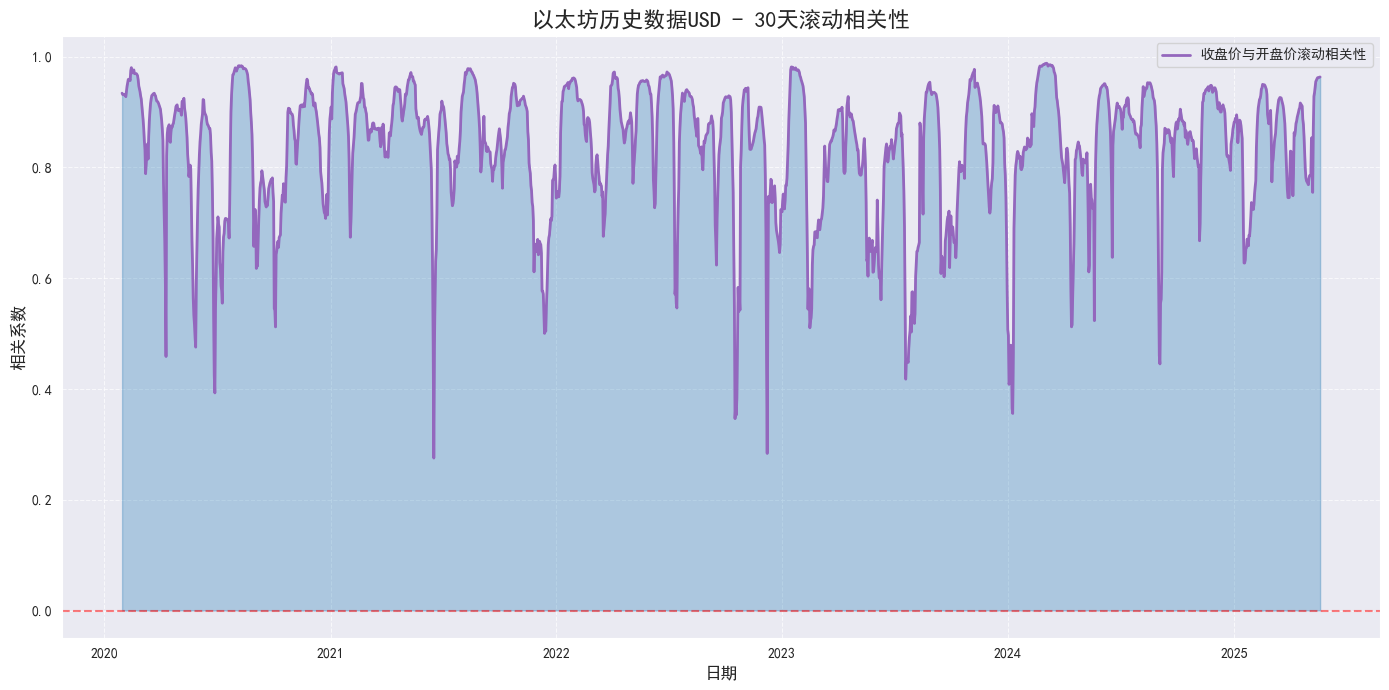

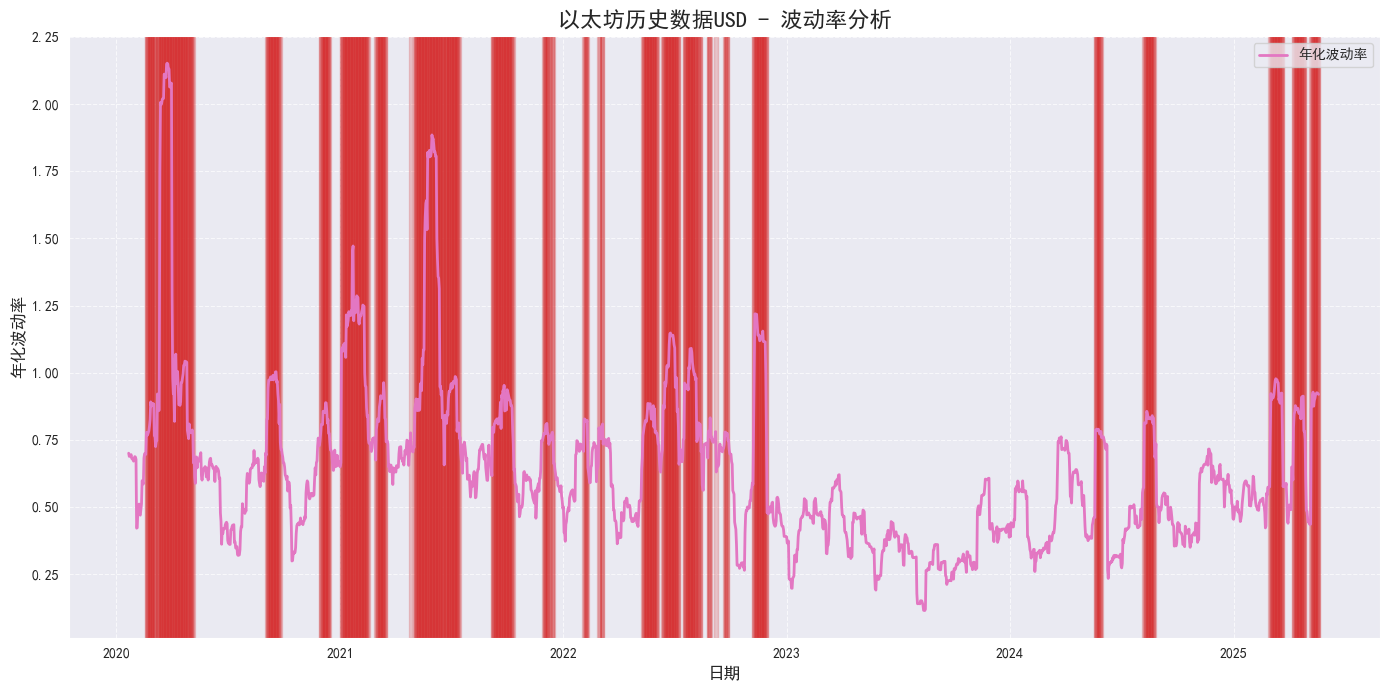

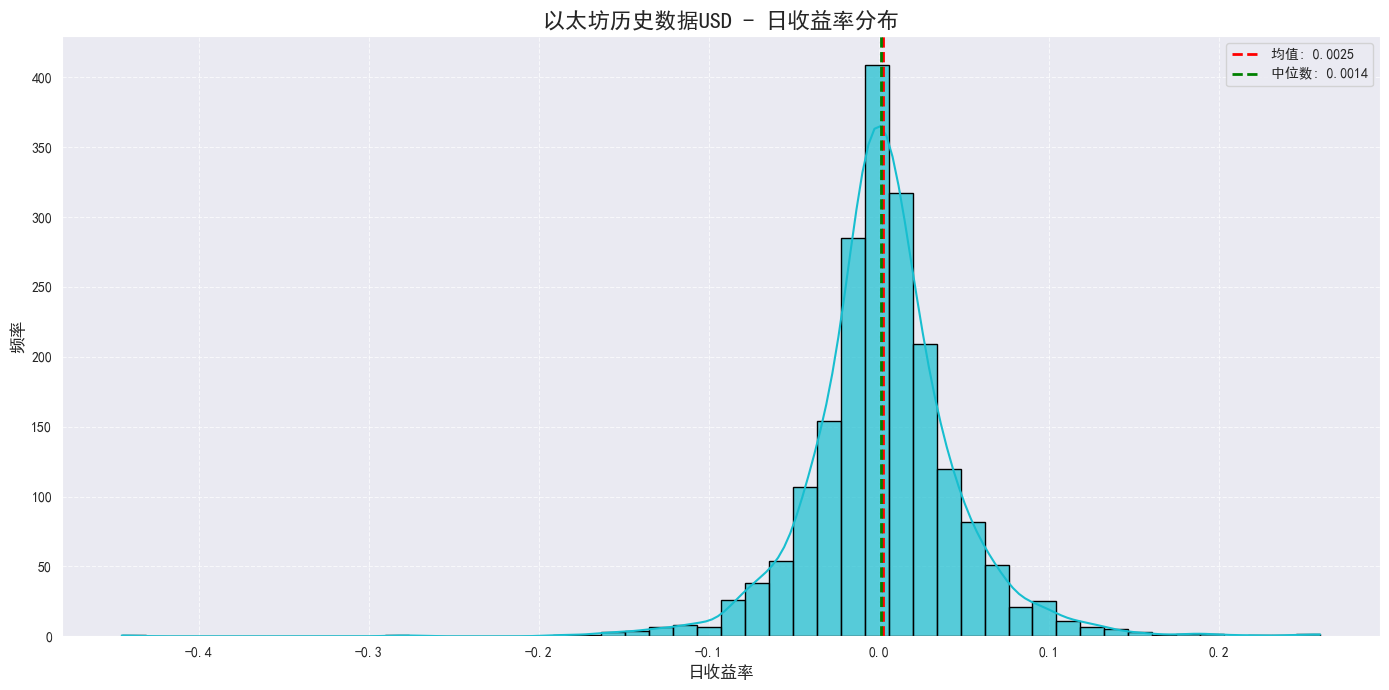

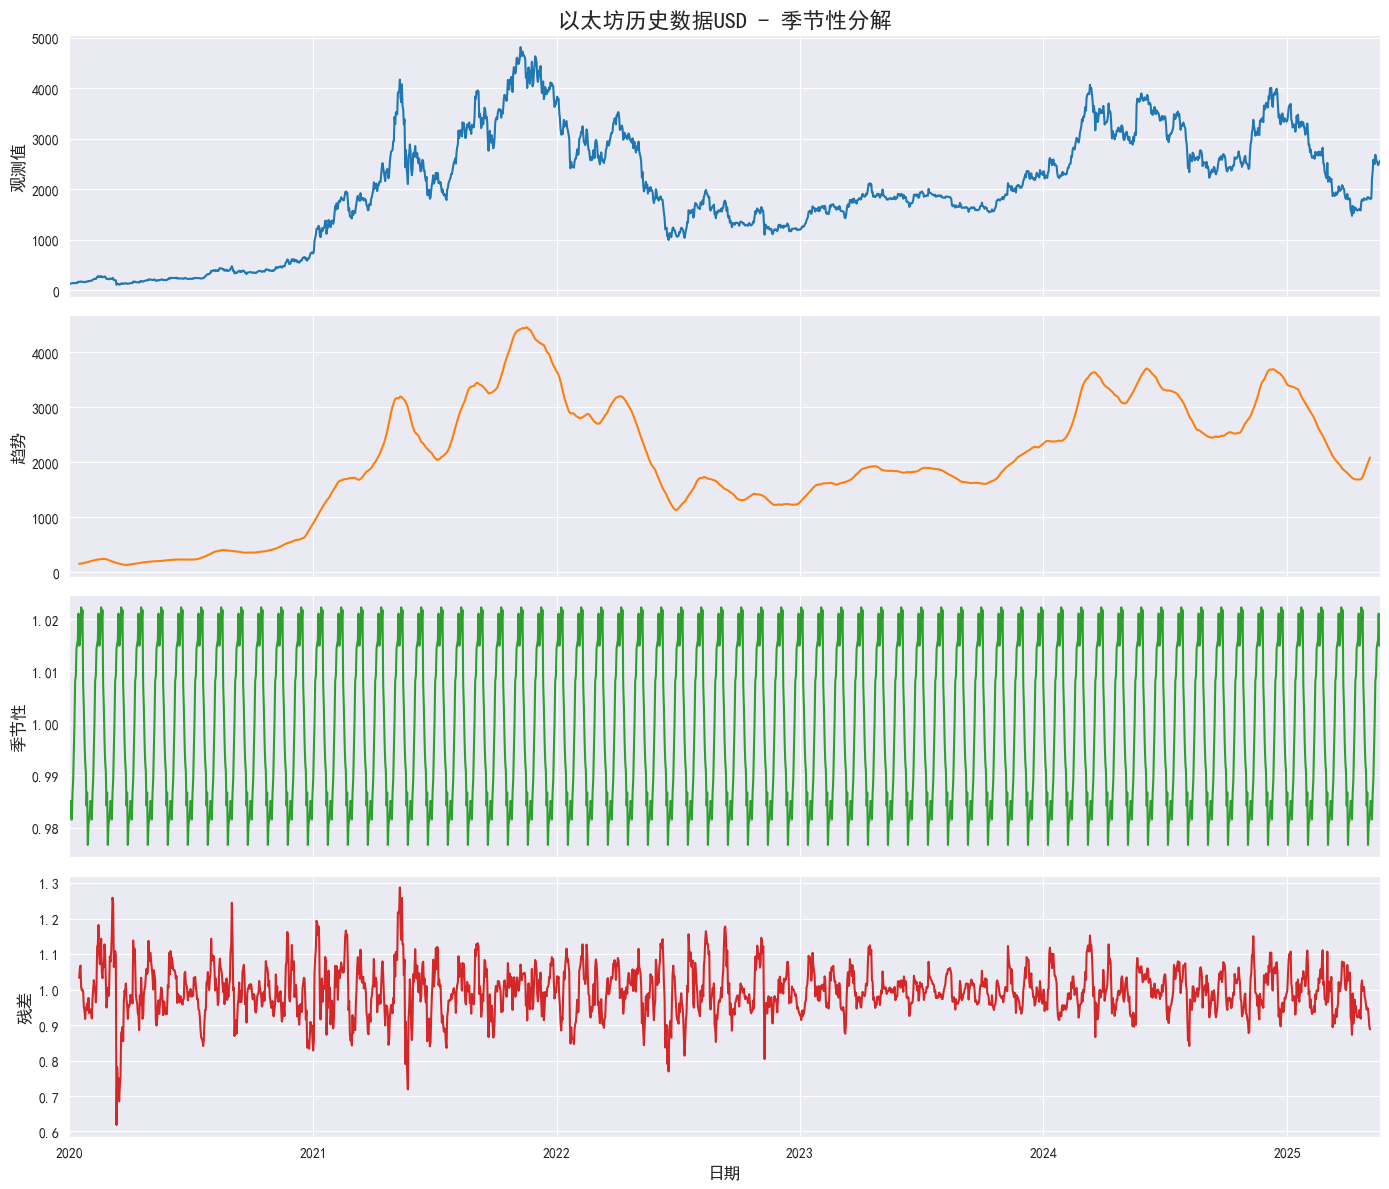

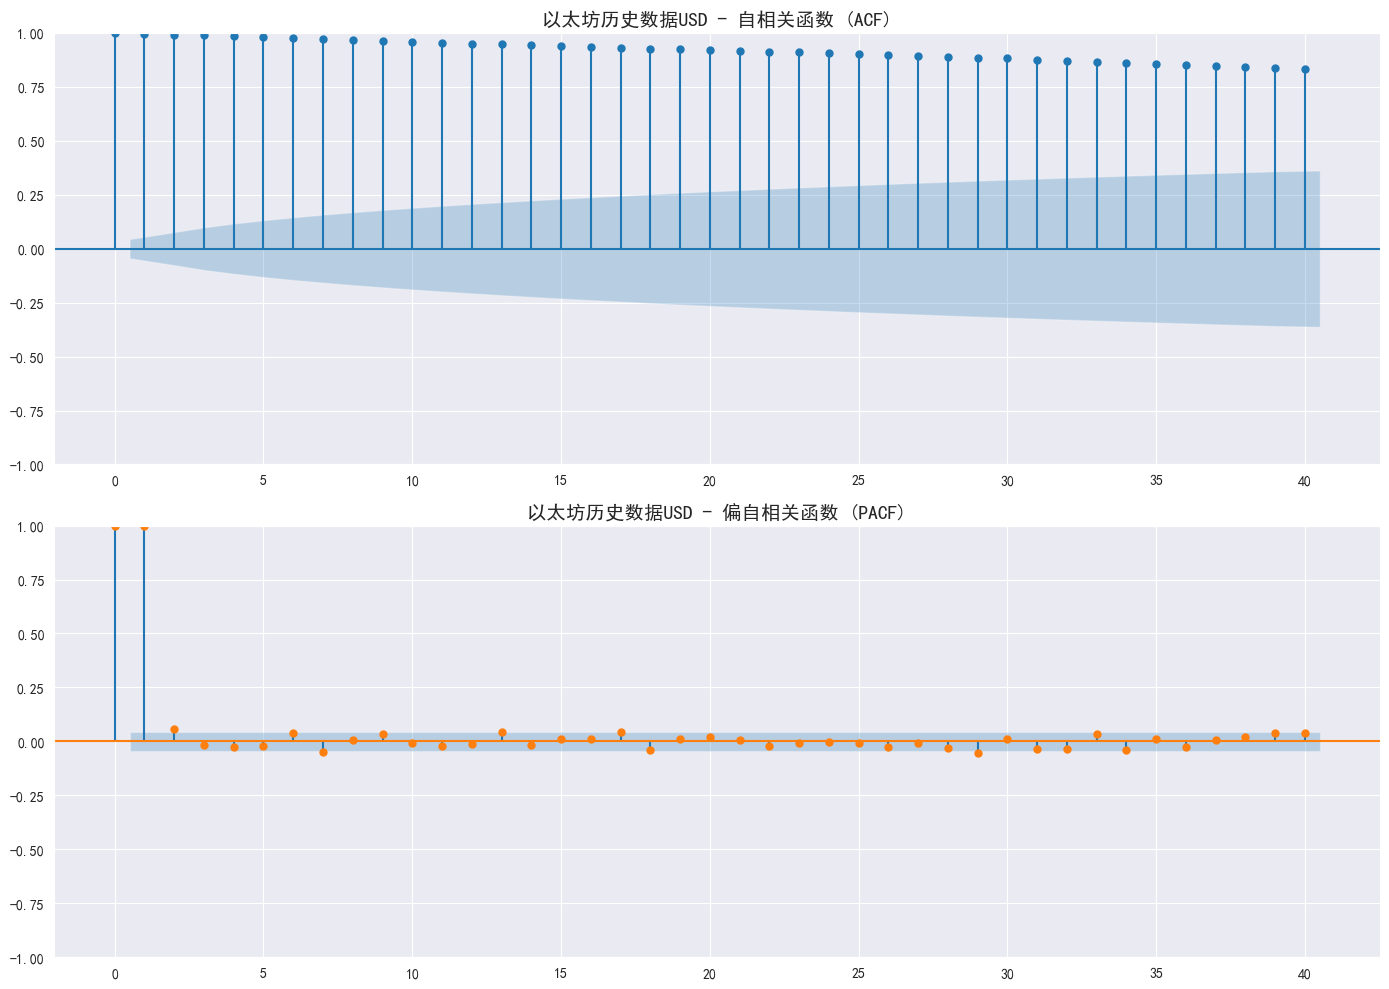

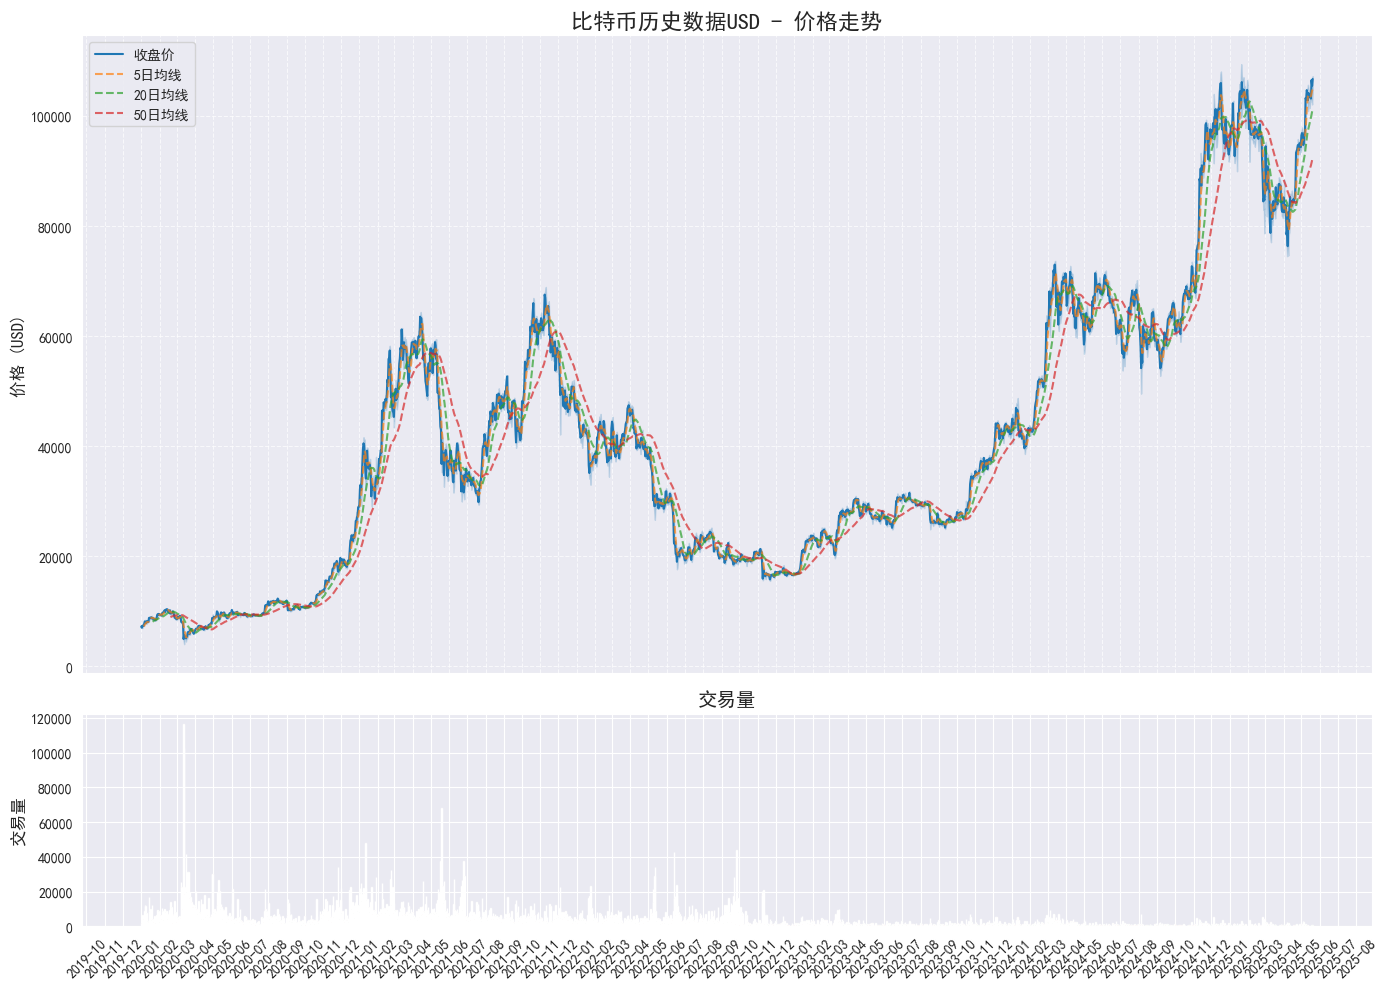

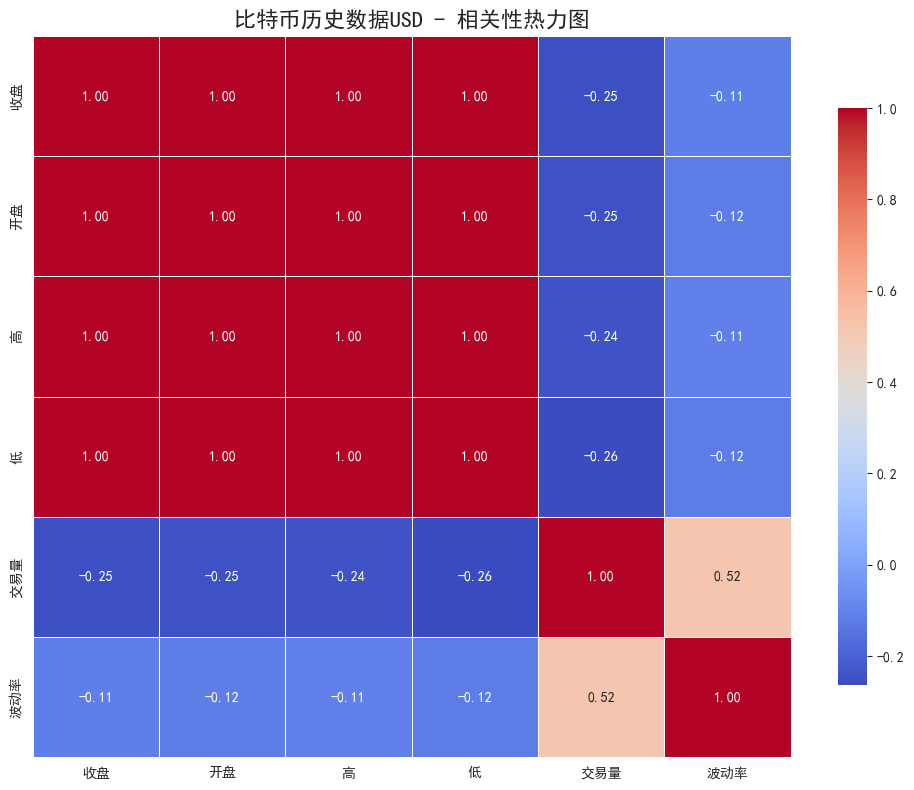

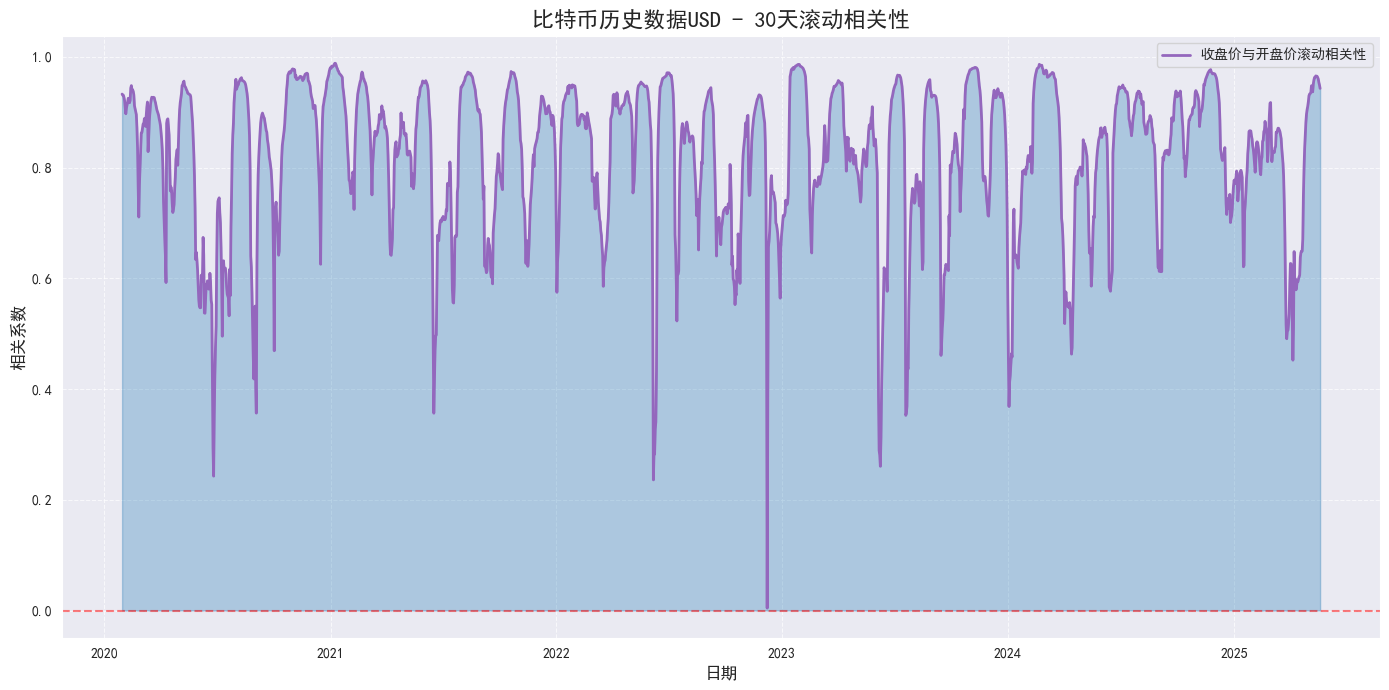

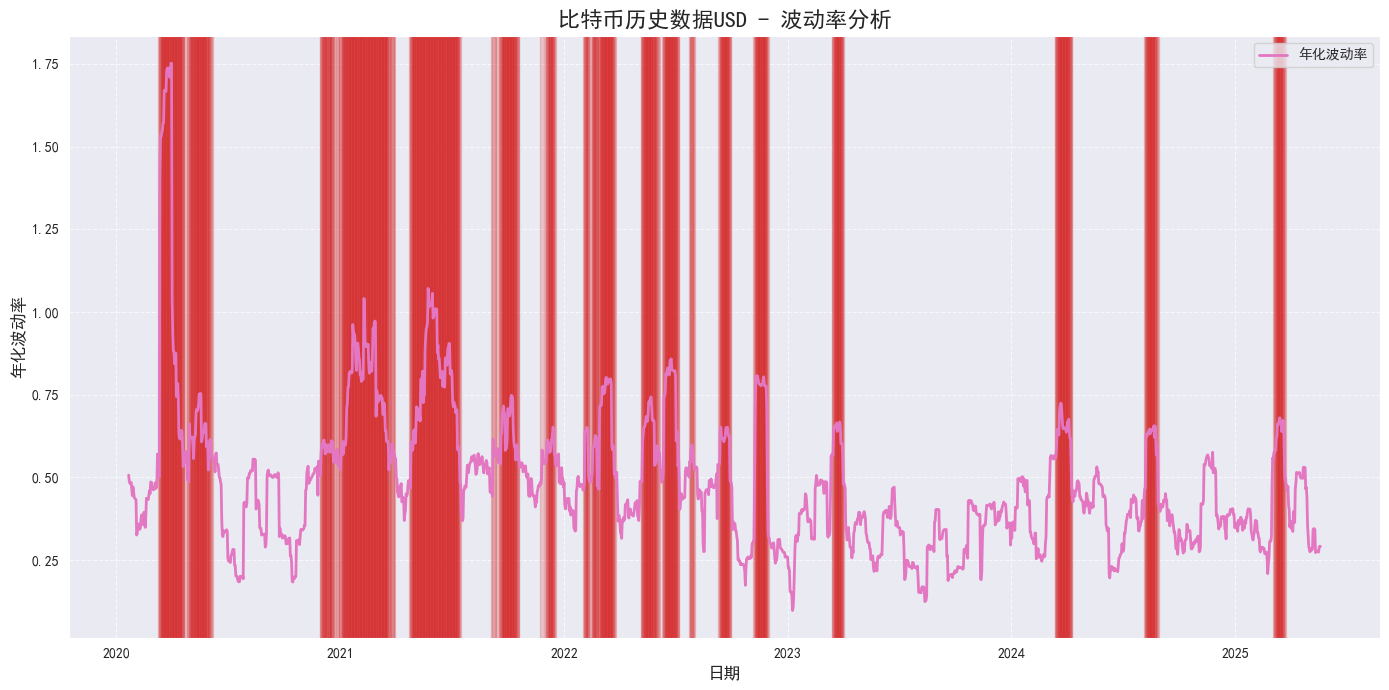

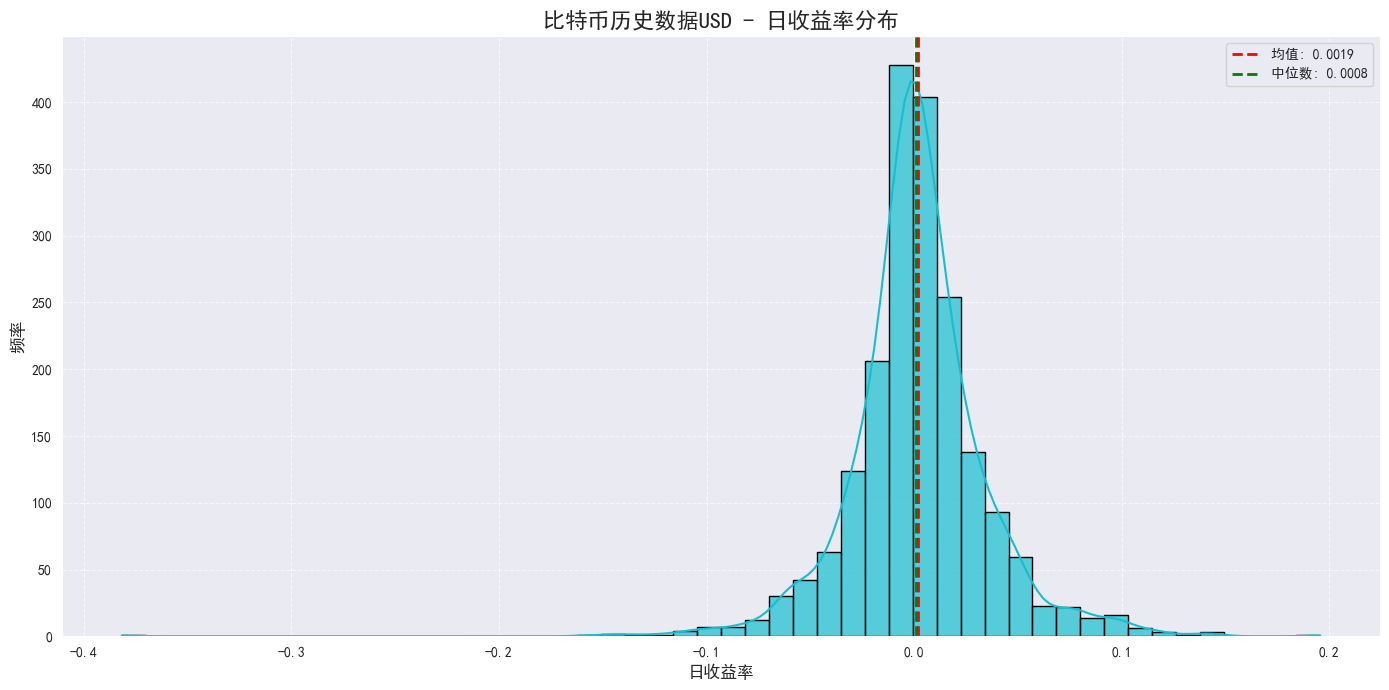

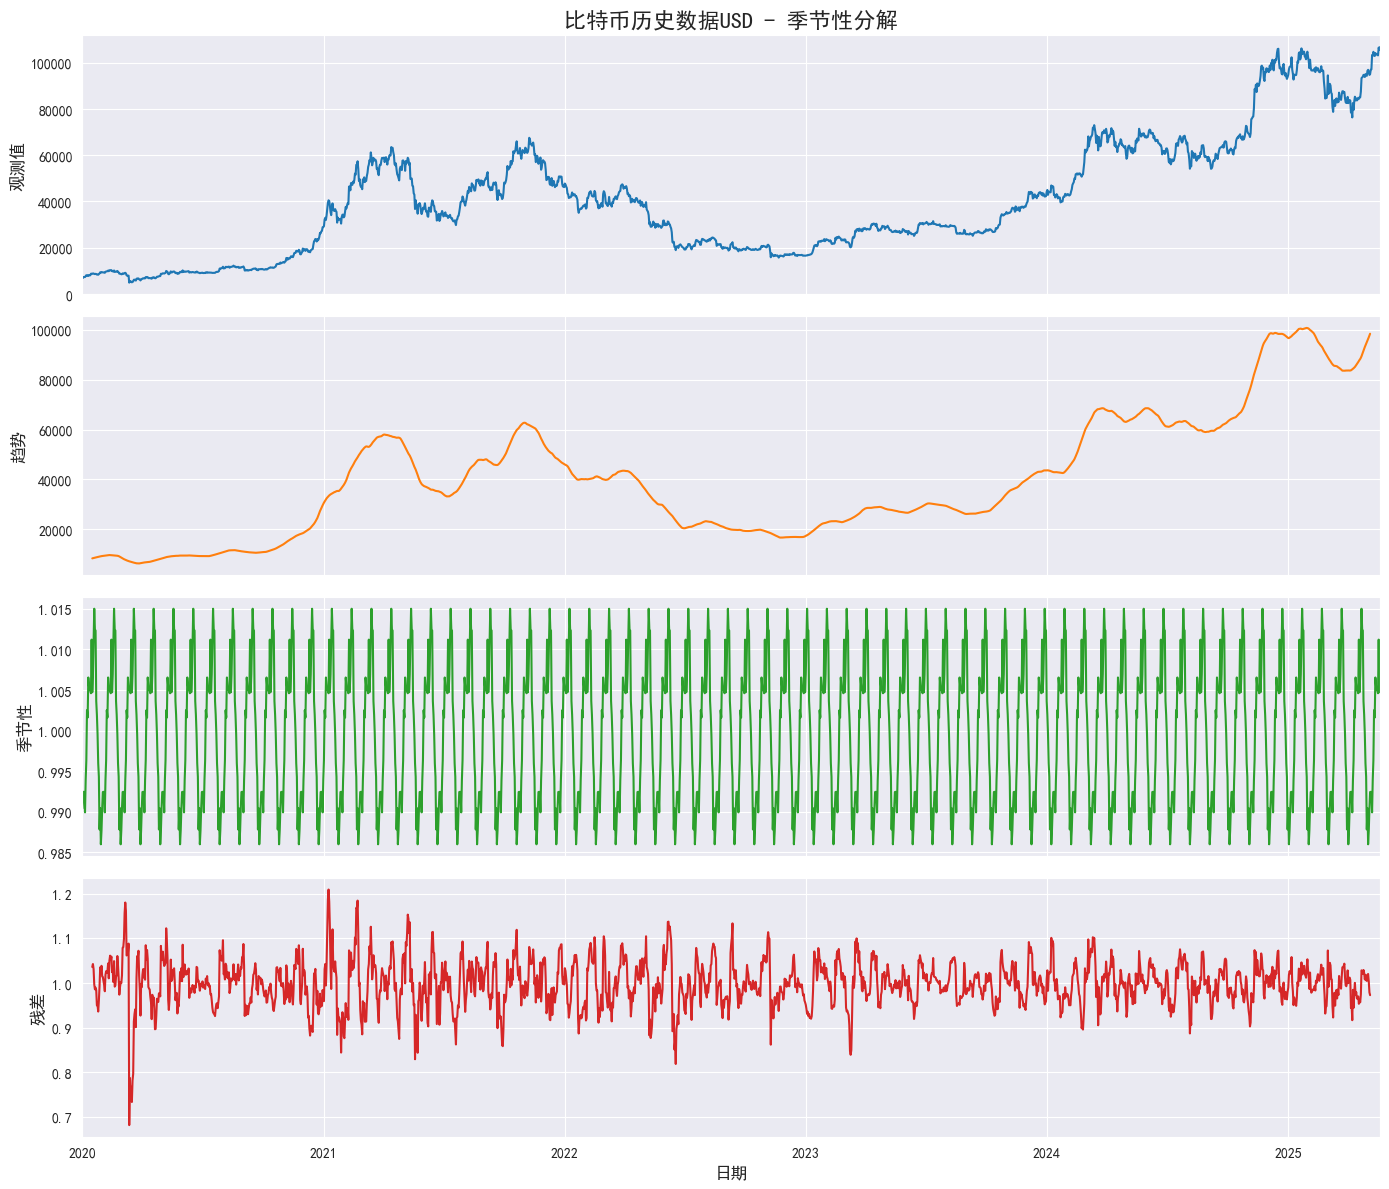

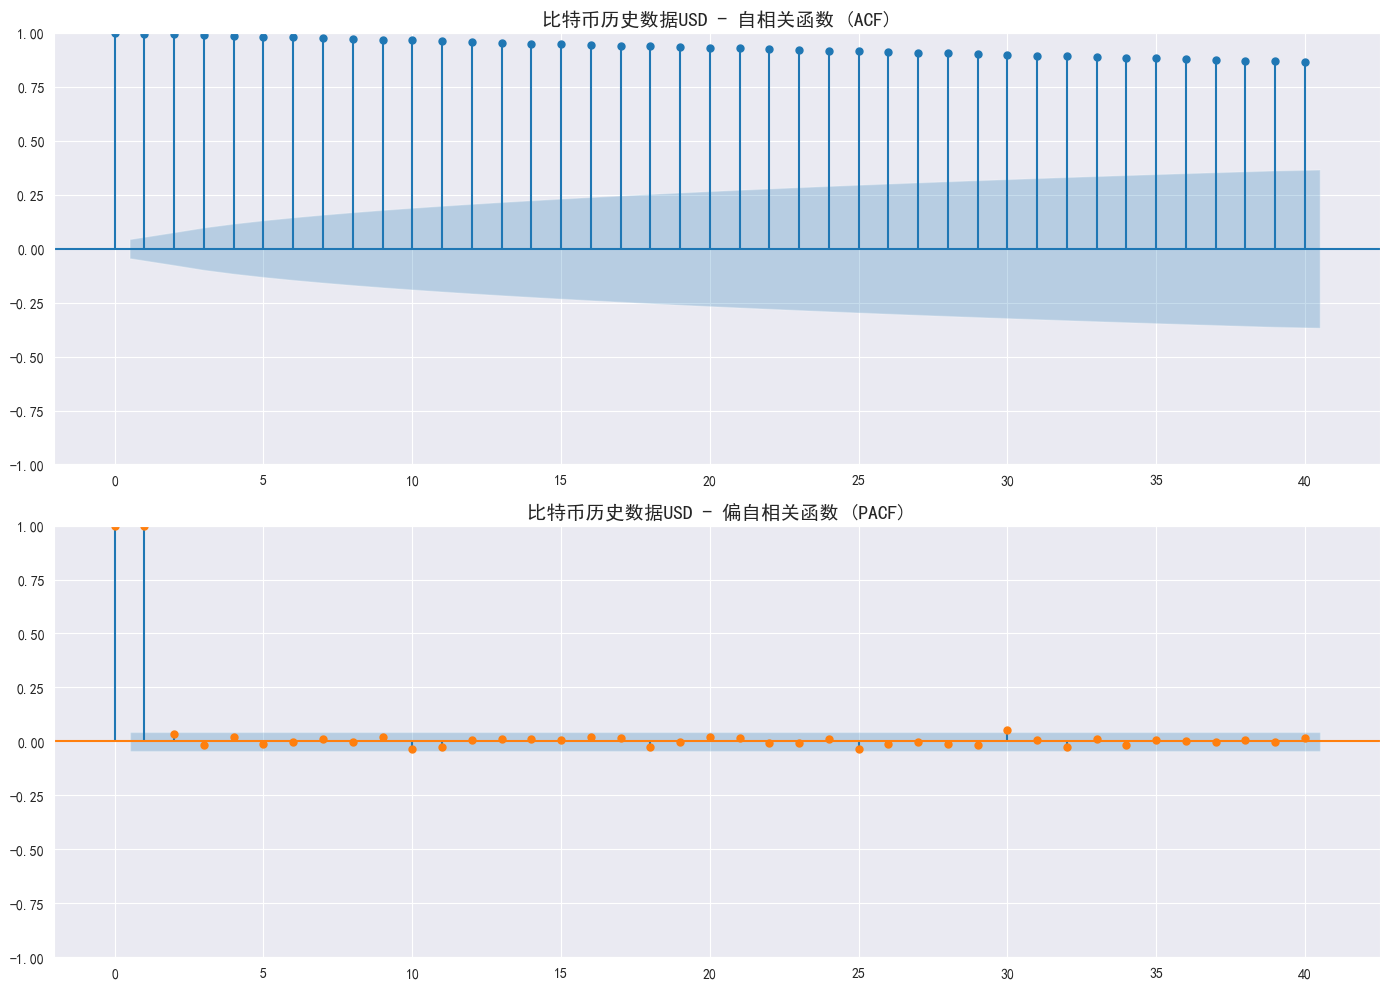

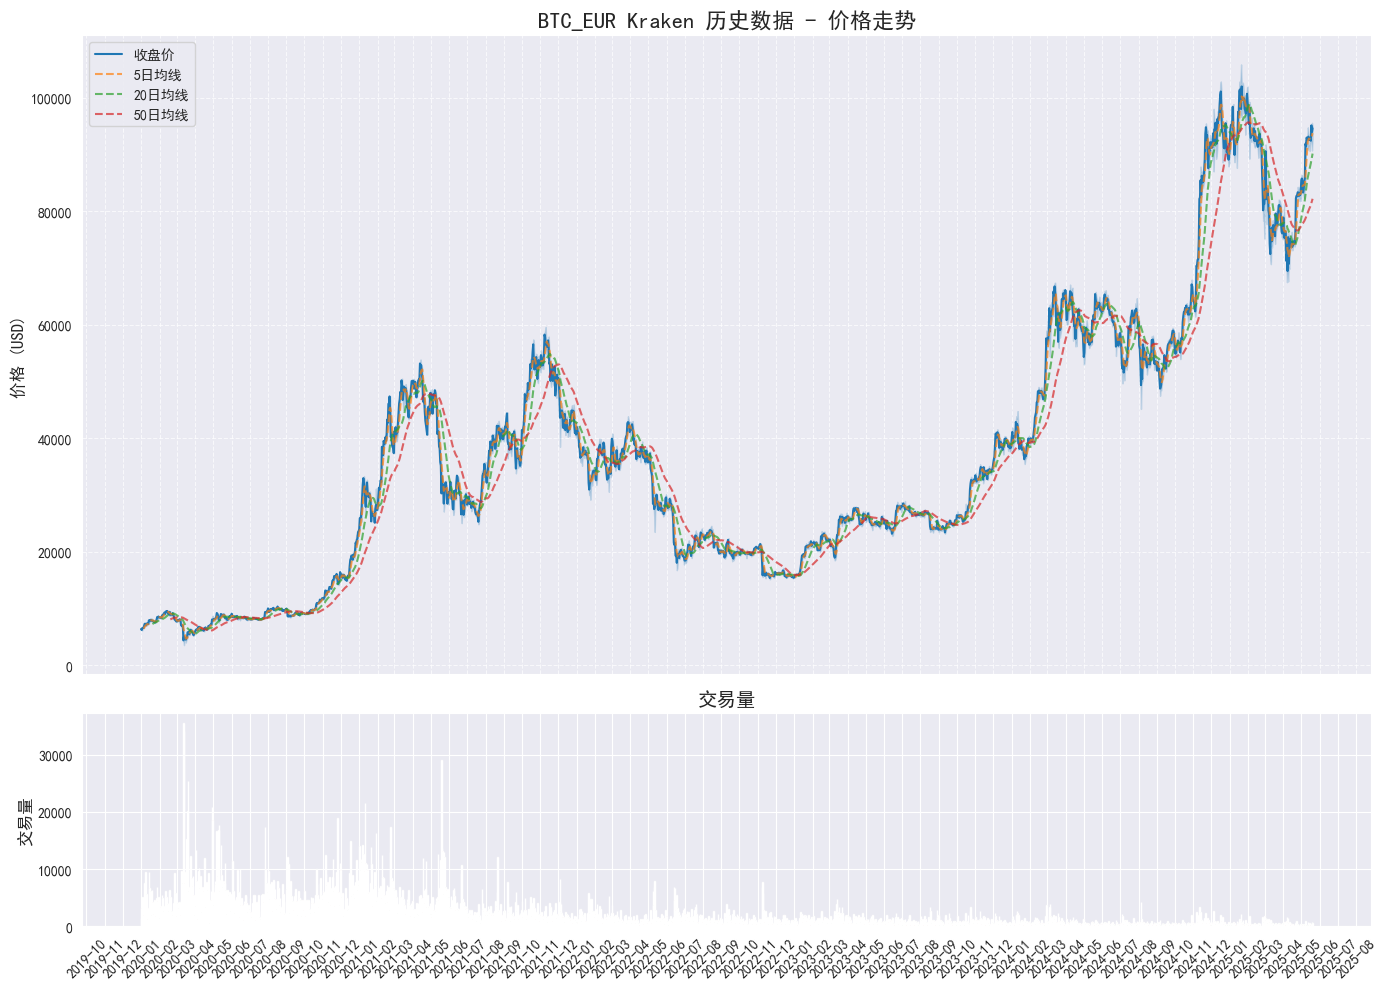

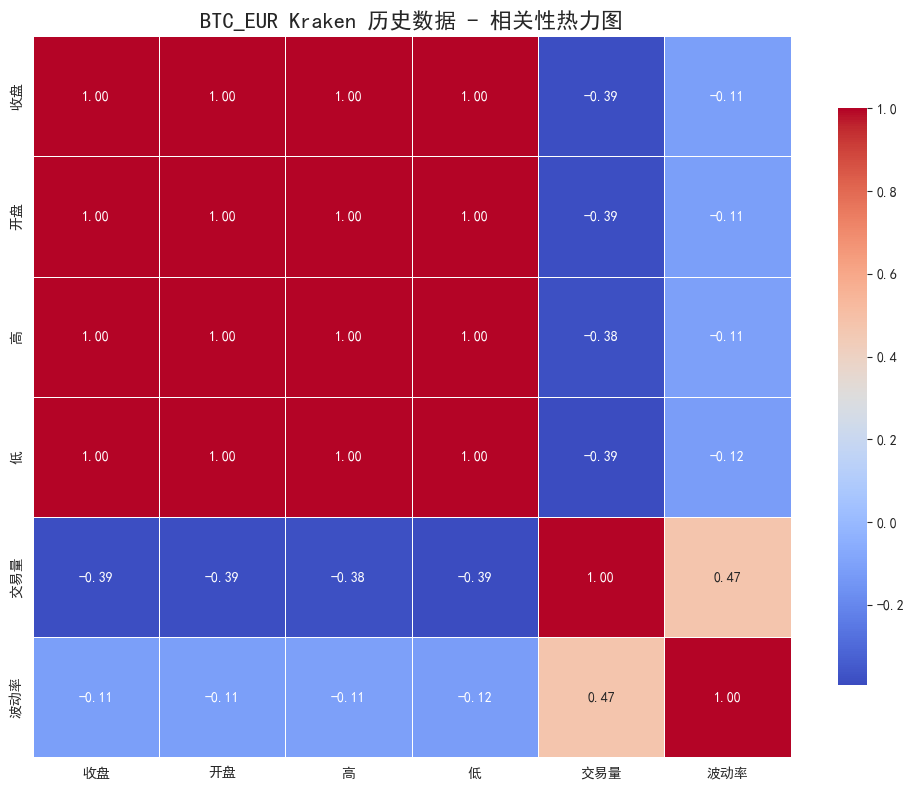

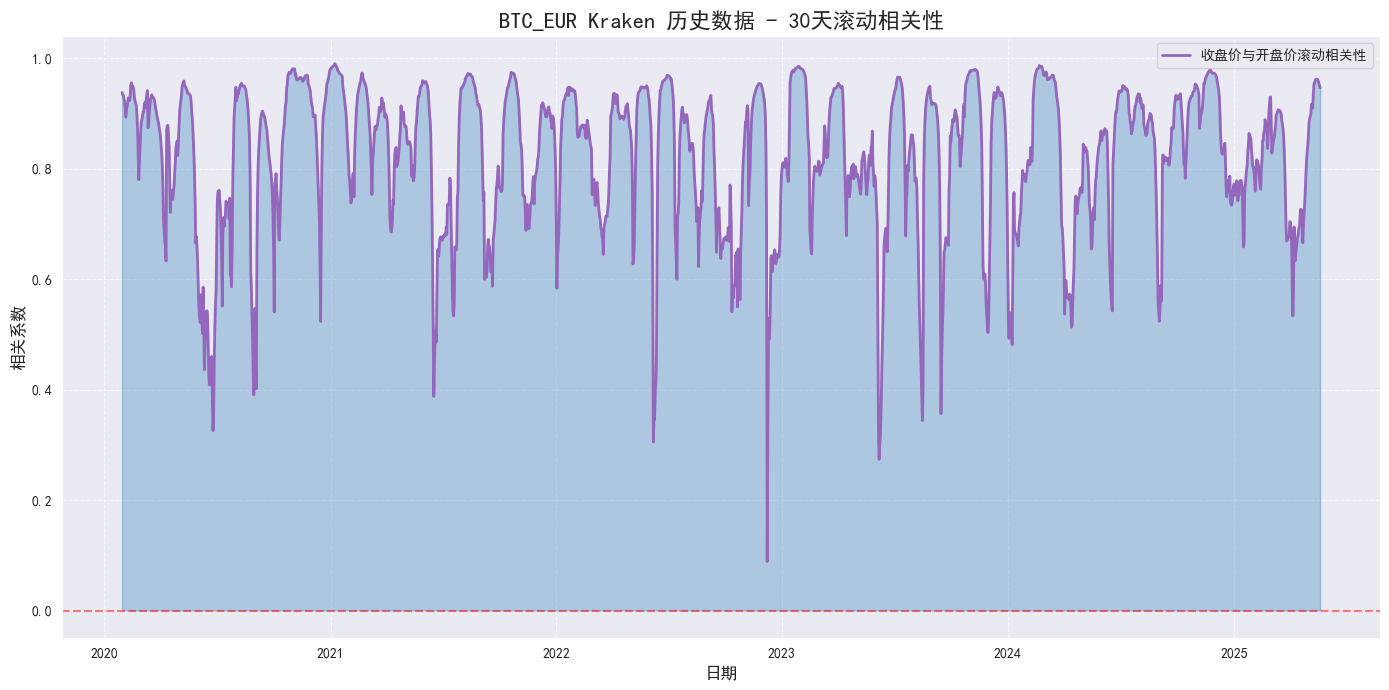

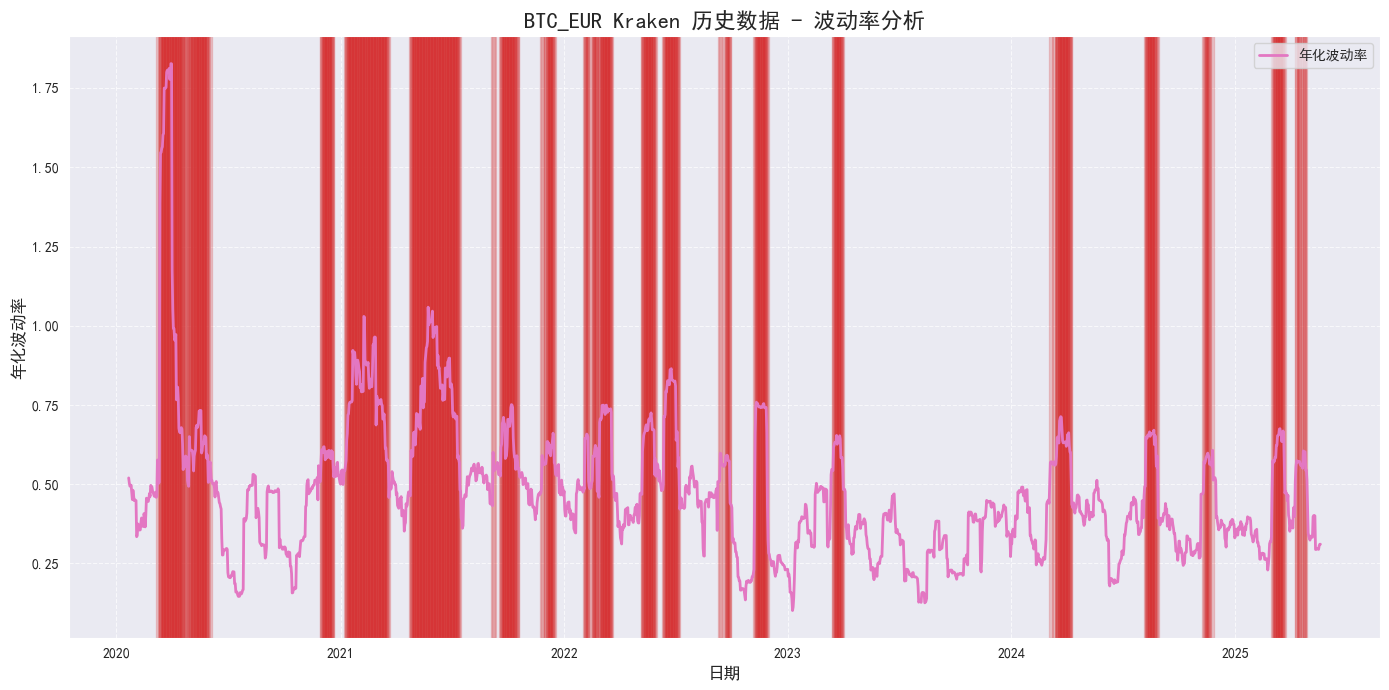

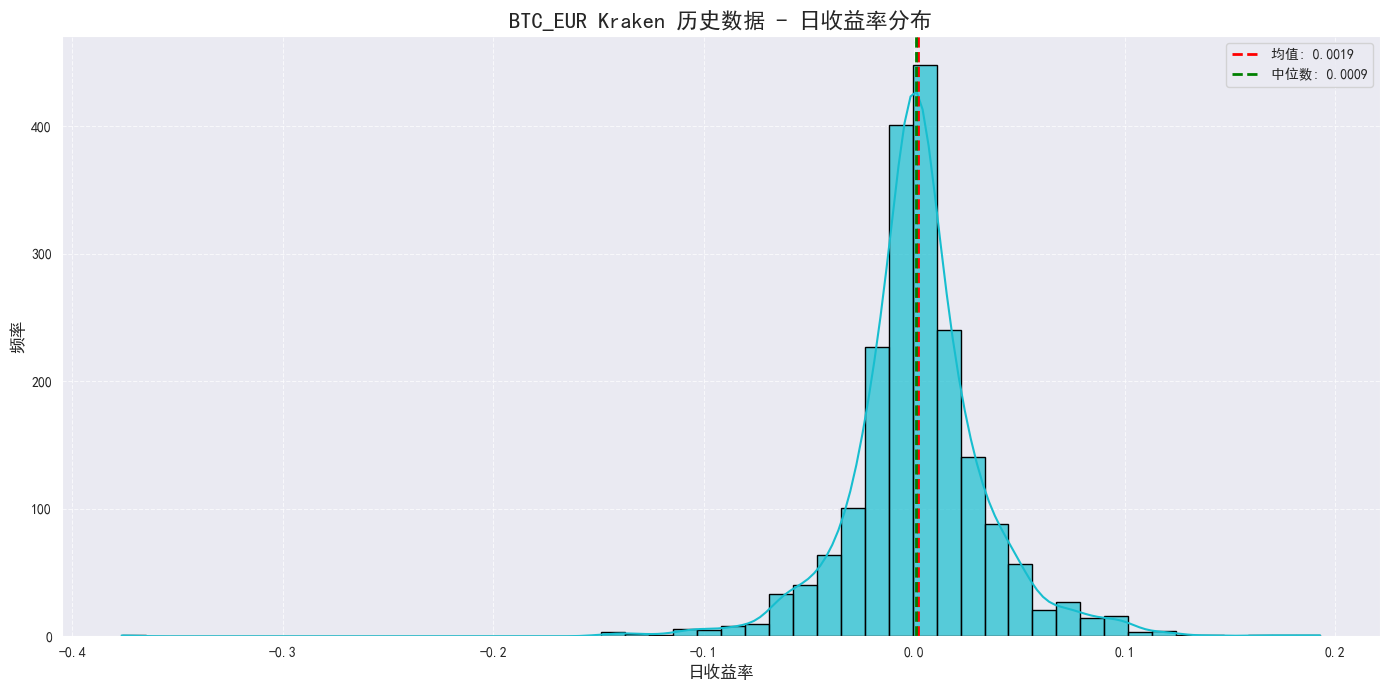

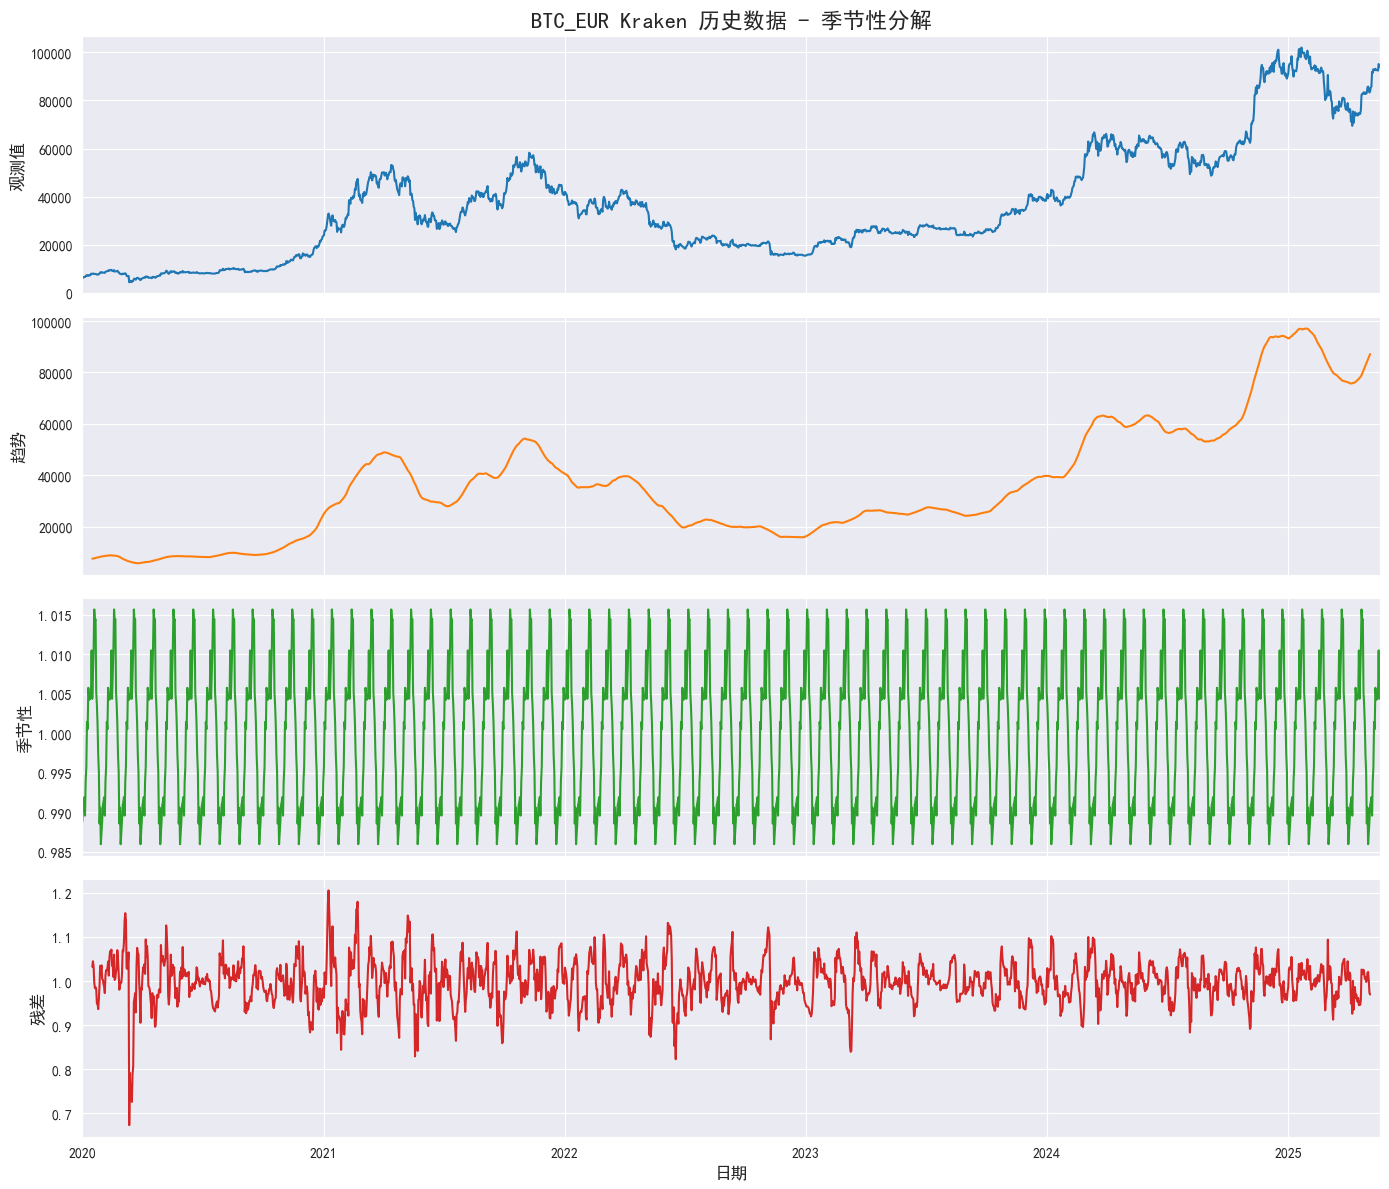

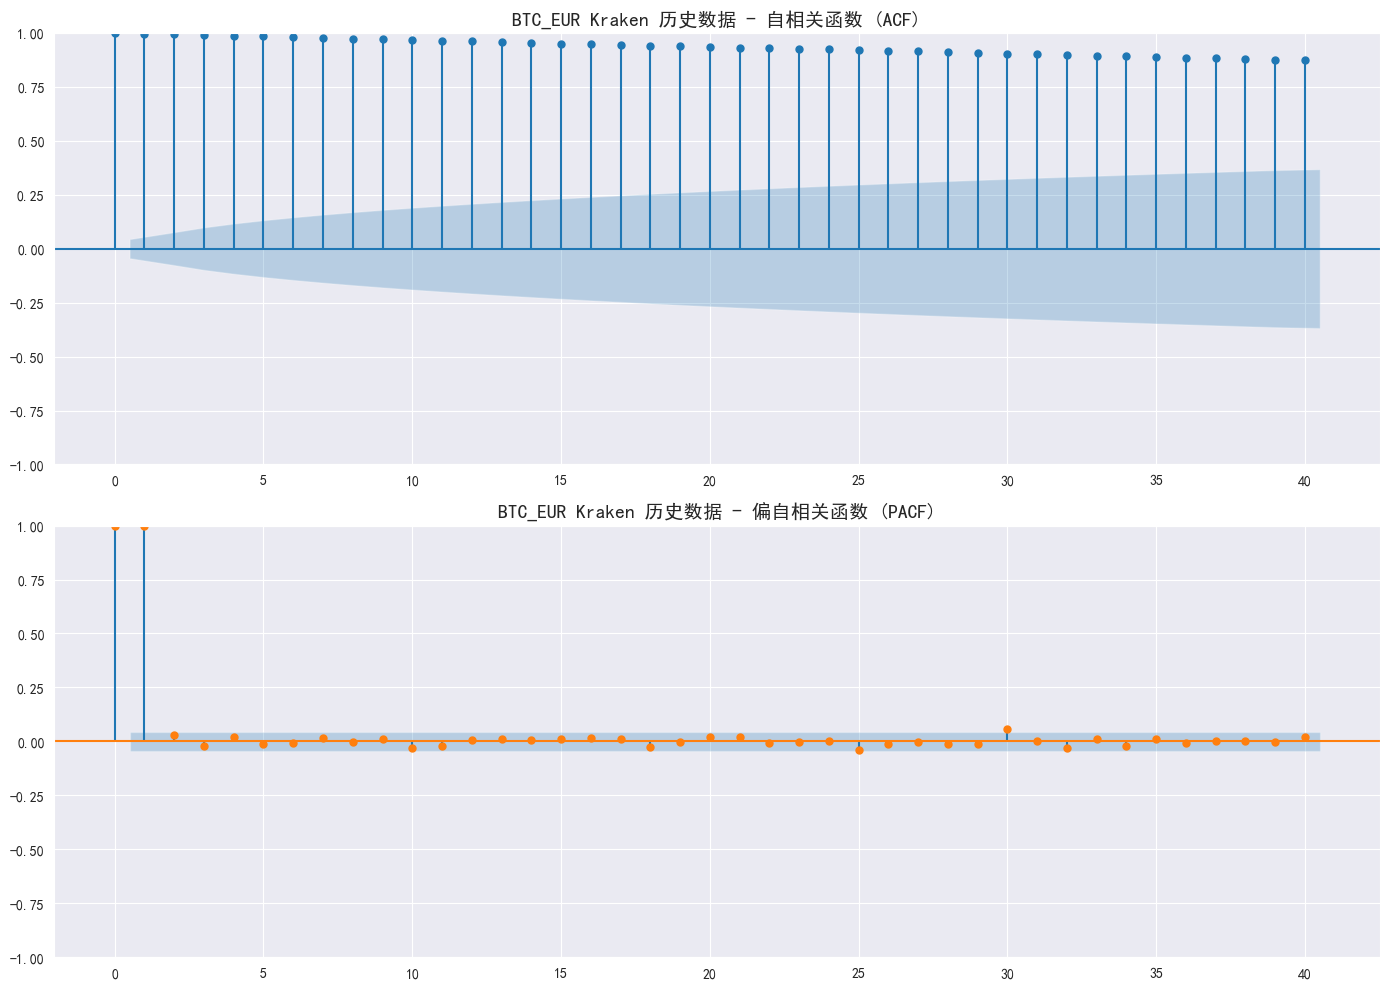

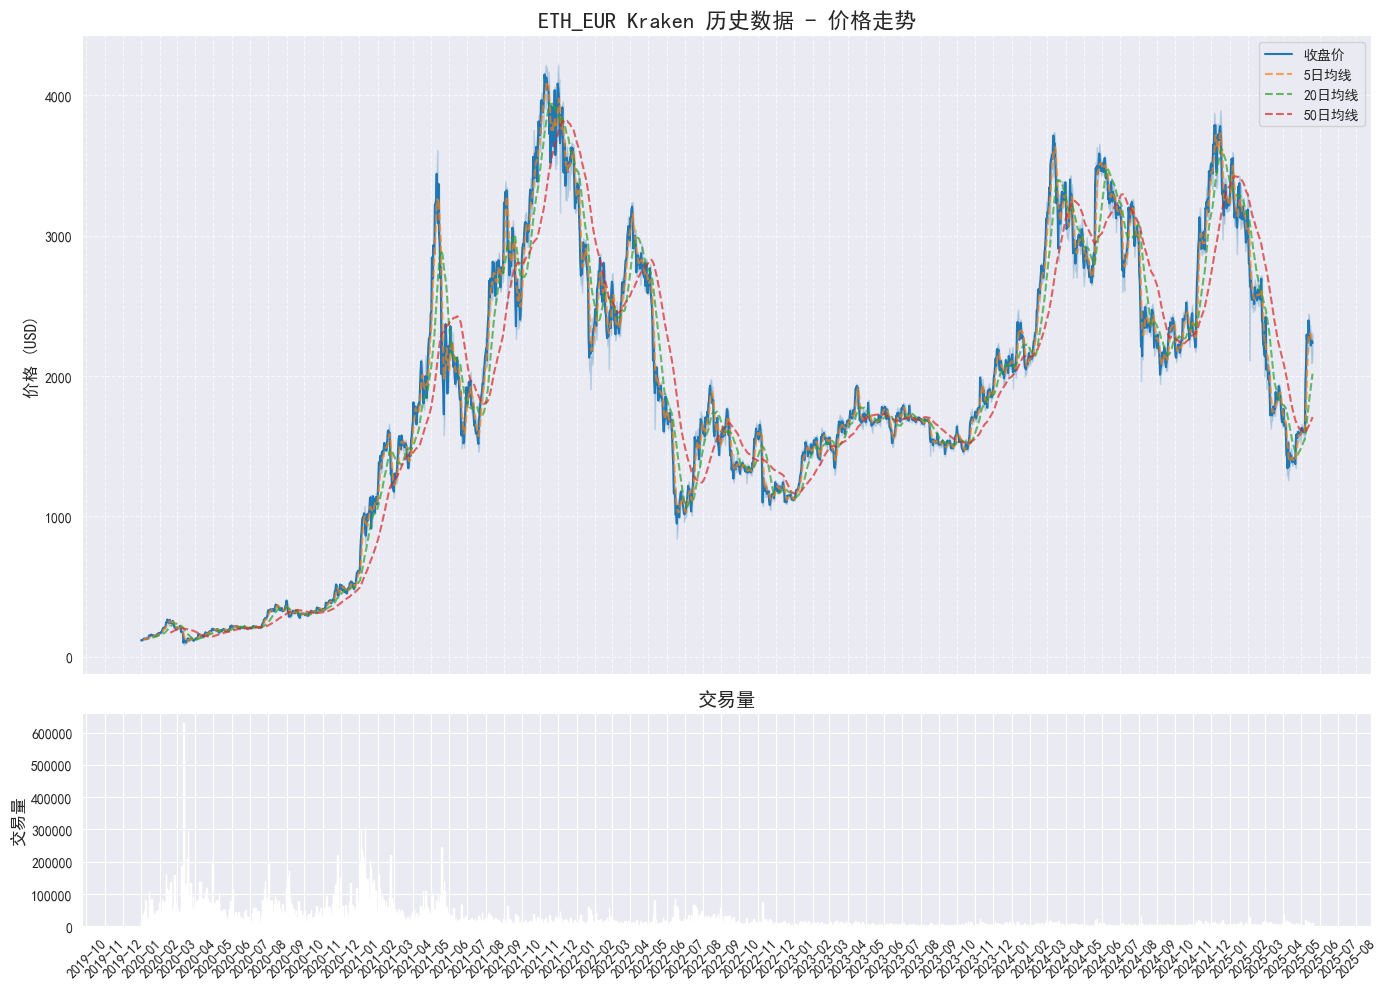

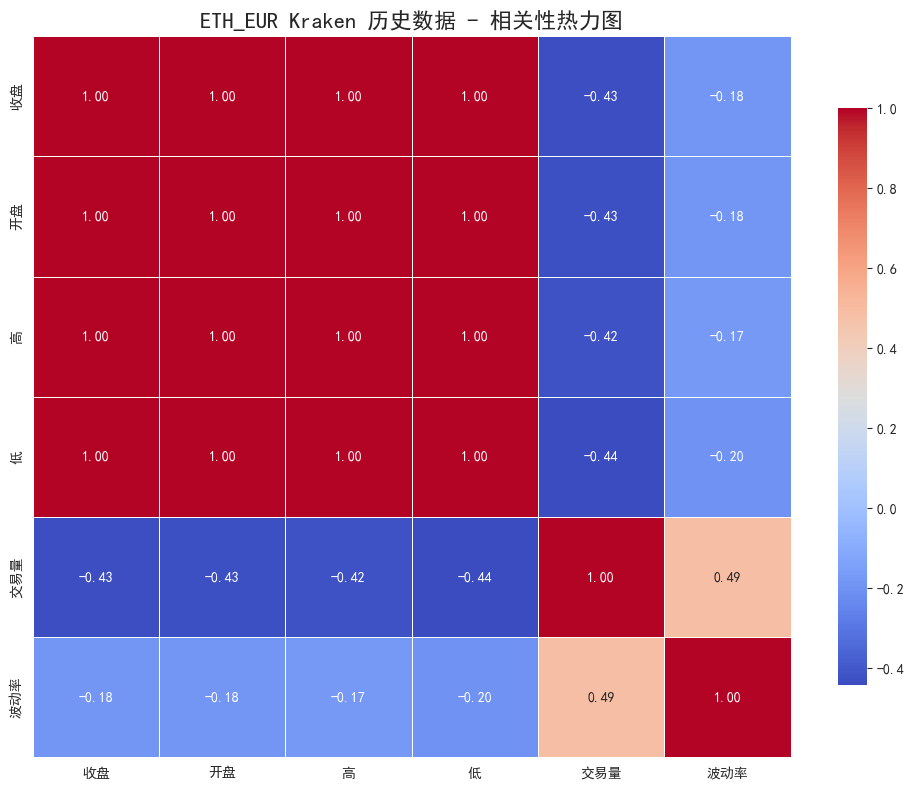

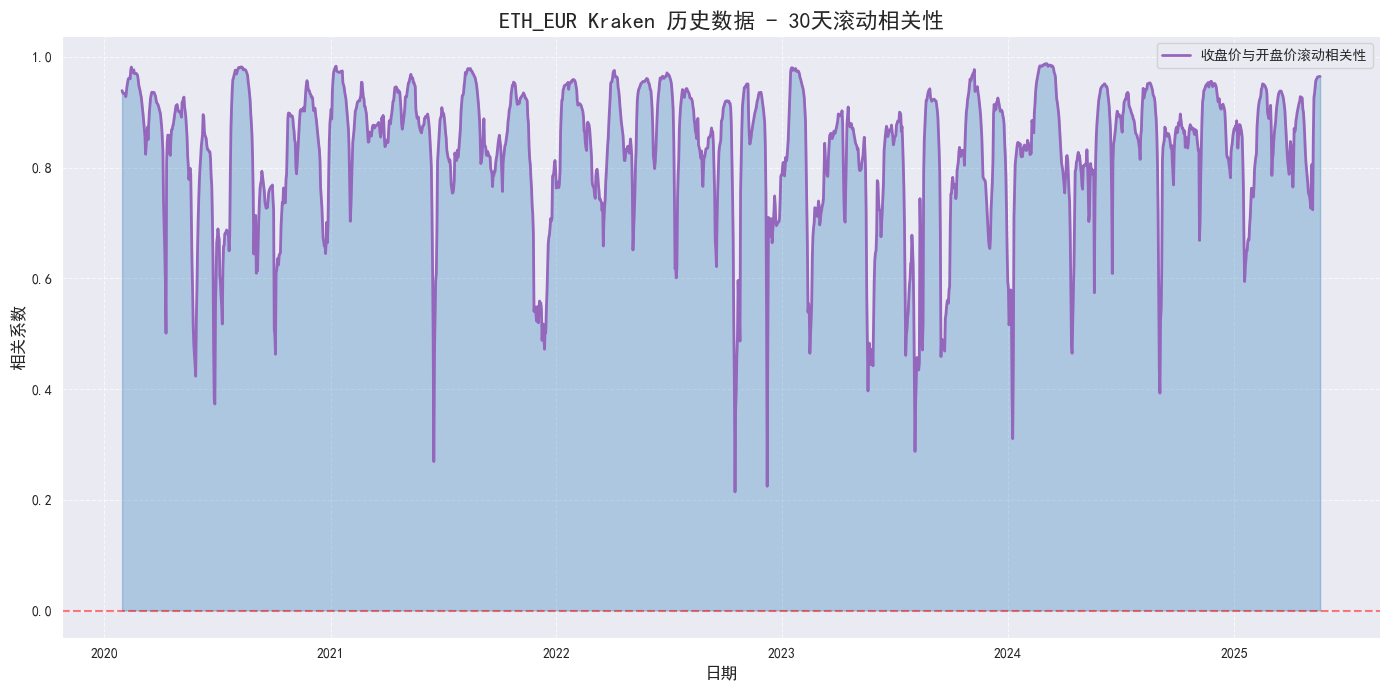

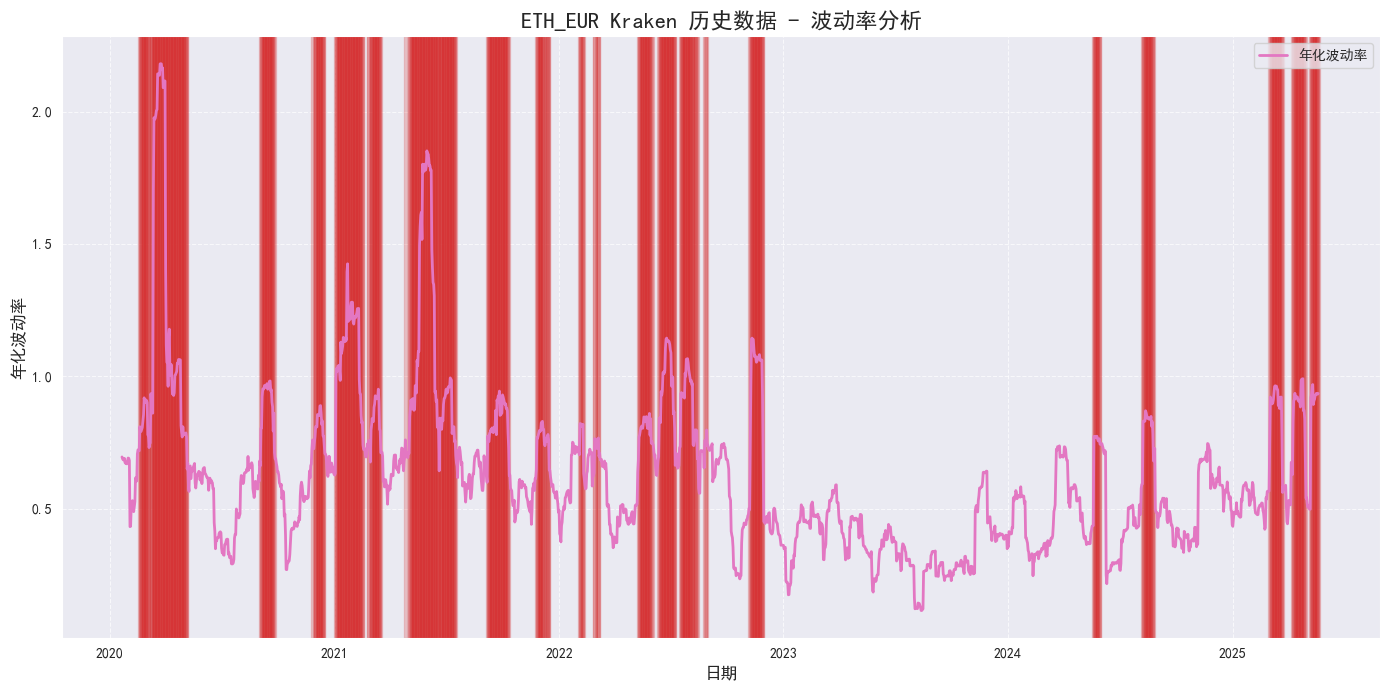

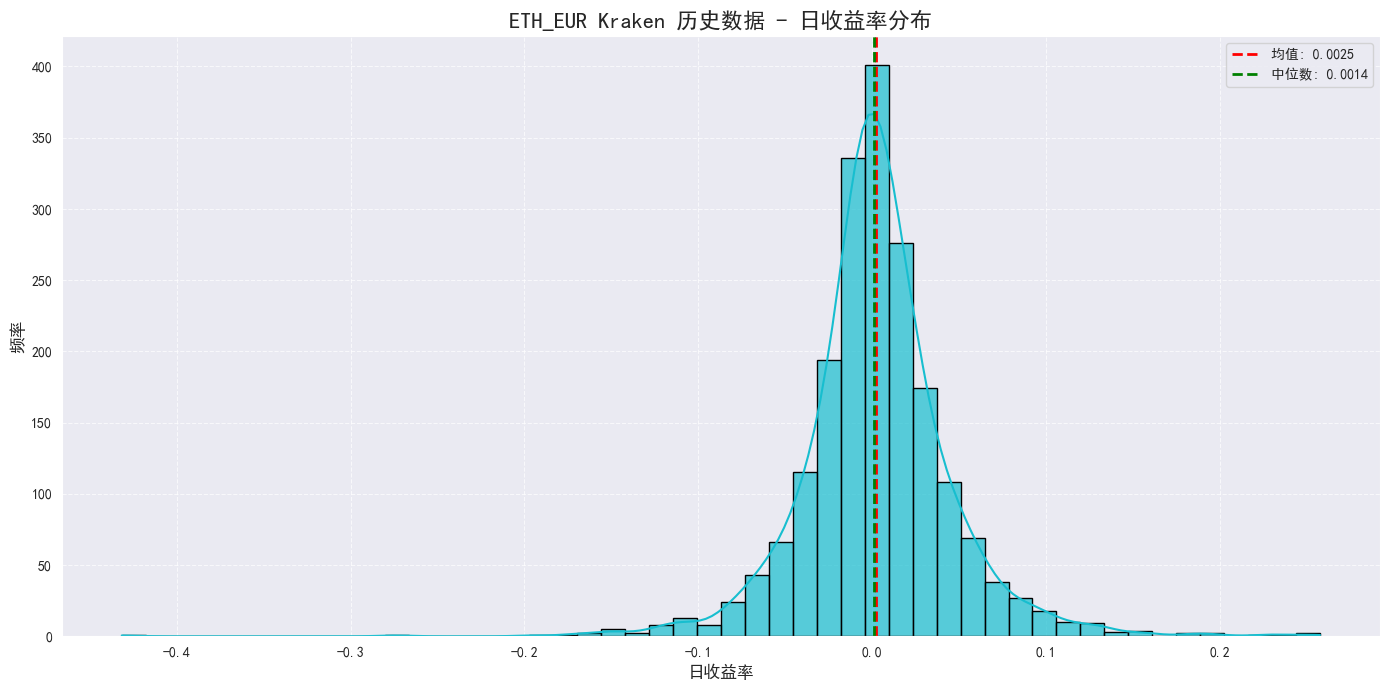

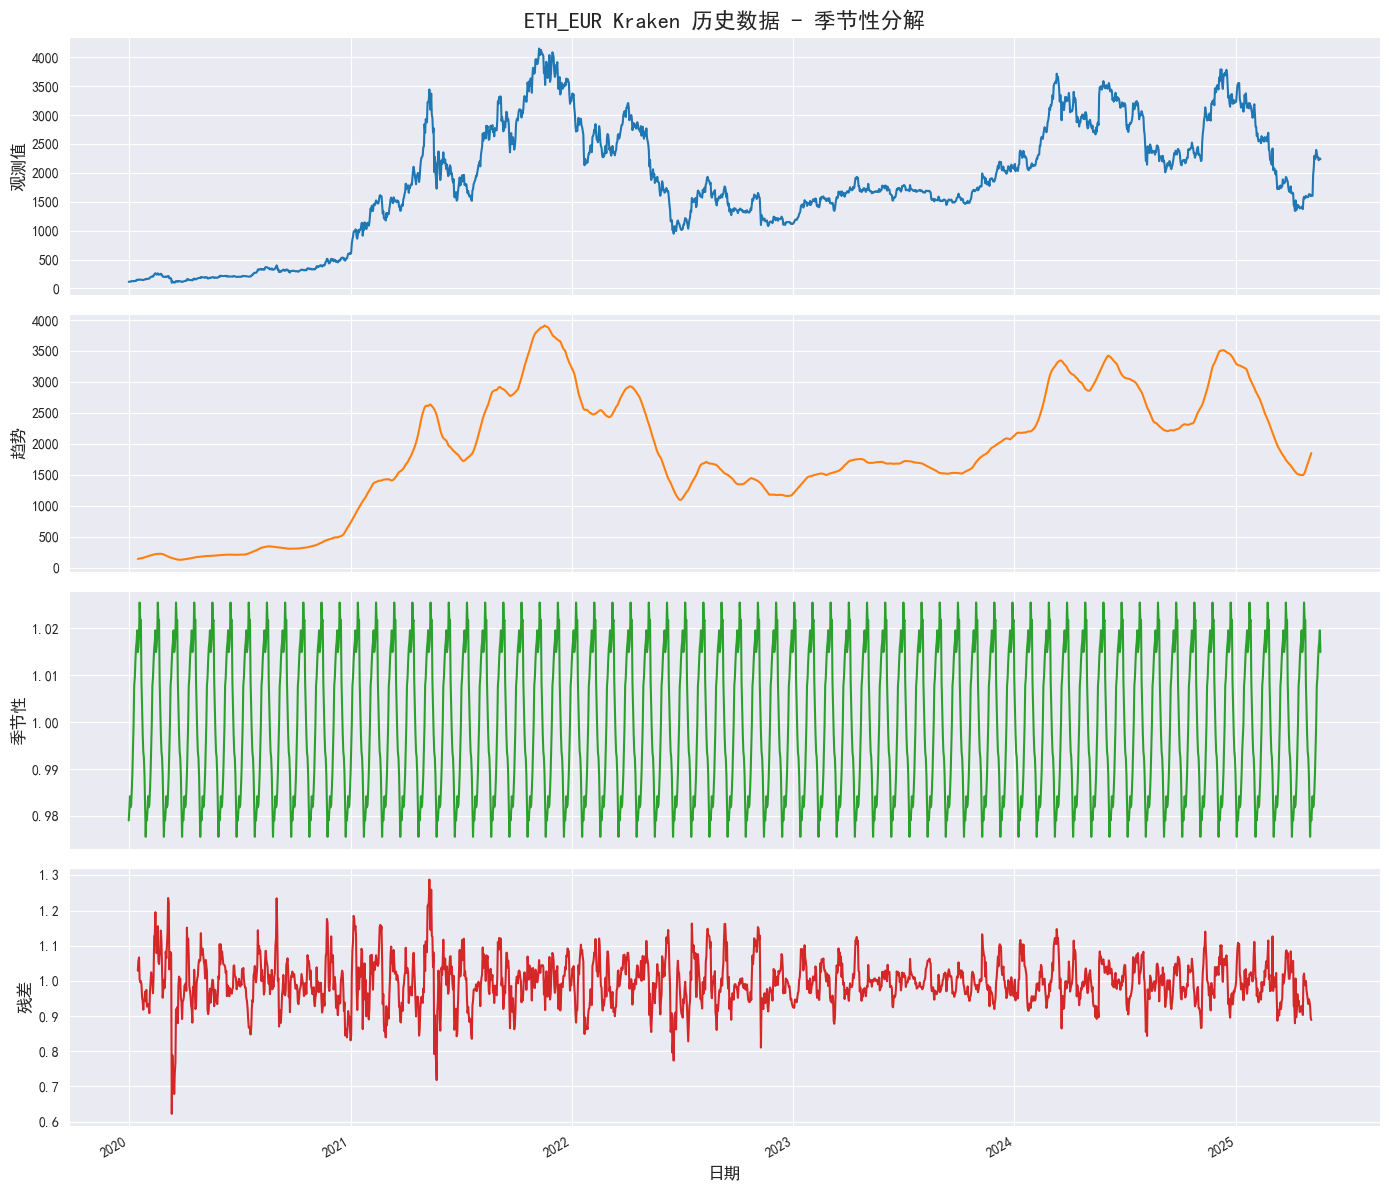

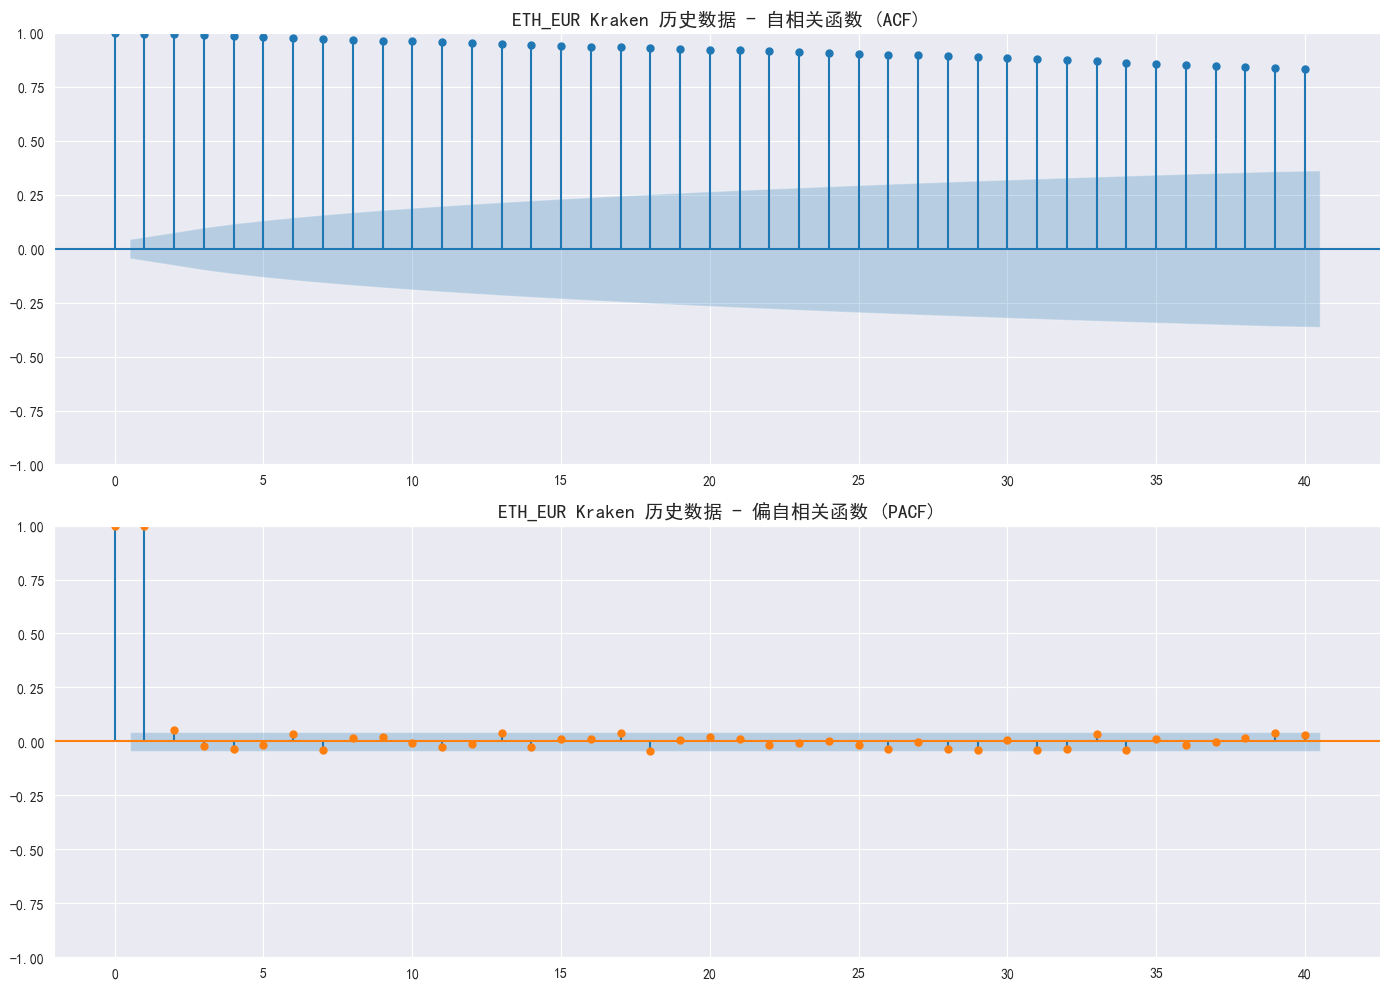

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import warnings

# 忽略警告信息，避免运行时出现大量警告干扰
warnings.filterwarnings('ignore')

# 设置可视化风格和字体配置，确保中文显示正常
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 8)  # 设置默认图表大小
plt.rcParams['axes.labelsize'] = 12  # 轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 图表标题字体大小
plt.rcParams['xtick.labelsize'] = 10  # X轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 10  # Y轴刻度标签大小

# 定义列名映射字典，将英文列名转换为中文
column_mapping = {
    'Date': '日期',
    'Close': '收盘',
    'Open': '开盘',
    'High': '高',
    'Low': '低',
    'Volume': '交易量',
    'Change': '涨跌幅'
}

def preprocess_data(data):
    """数据预处理函数，包括列名转换、数据类型转换和缺失值处理"""
    # 重命名列
    data.columns = data.columns.str.strip()  # 去除列名前后空格
    data = data.rename(columns=column_mapping)
    
    # 转换日期格式为 datetime 类型
    data['日期'] = pd.to_datetime(data['日期'], errors='coerce')
    
    # 将价格列转换为数值类型，去除可能存在的逗号分隔符
    for col in ['收盘', '开盘', '高', '低']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')
    
    # 处理交易量格式 (如 "914.76K" 转换为 914760)
    if '交易量' in data.columns:
        def convert_volume(x):
            if isinstance(x, str):
                if 'K' in x:
                    return float(x.replace('K', '')) * 1000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                else:
                    return float(x)
            return x
        
        data['交易量'] = data['交易量'].apply(convert_volume)
    
    # 处理涨跌幅，转换为小数形式
    if '涨跌幅' in data.columns:
        data['涨跌幅'] = data['涨跌幅'].str.replace('%', '').astype(float) / 100
    
    # 按日期排序并设置为索引
    data = data.sort_values('日期').set_index('日期')
    
    # 填充缺失值，使用前向填充和后向填充
    data = data.ffill().bfill()
    
    # 添加技术指标：均线和收益率
    if '收盘' in data.columns:
        data['5日均线'] = data['收盘'].rolling(window=5).mean()
        data['20日均线'] = data['收盘'].rolling(window=20).mean()
        data['50日均线'] = data['收盘'].rolling(window=50).mean()
        data['日收益率'] = data['收盘'].pct_change()
        data['波动率'] = data['日收益率'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    
    return data  # 返回预处理后的数据

def plot_price_volume(data, title):
    """绘制价格和交易量图表，包含均线和价格区间"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # 绘制价格图表，包含多种均线
    ax1.plot(data.index, data['收盘'], label='收盘价', color='#1f77b4', linewidth=1.5)
    ax1.plot(data.index, data['5日均线'], label='5日均线', color='#ff7f0e', linestyle='--', alpha=0.7)
    ax1.plot(data.index, data['20日均线'], label='20日均线', color='#2ca02c', linestyle='--', alpha=0.7)
    ax1.plot(data.index, data['50日均线'], label='50日均线', color='#d62728', linestyle='--', alpha=0.7)
    ax1.fill_between(data.index, data['低'], data['高'], color='#1f77b4', alpha=0.2)  # 填充每日价格区间
    
    ax1.set_title(f'{title} - 价格走势', fontsize=16)
    ax1.set_ylabel('价格 (USD)', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 绘制交易量图表，使用颜色区分涨跌
    ax2.bar(data.index, data['交易量'], color=np.where(data['收盘'] > data['收盘'].shift(1), '#2ca02c', '#d62728'), width=1)
    ax2.set_title('交易量', fontsize=14)
    ax2.set_ylabel('交易量', fontsize=12)
    
    # 设置日期格式
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{title}_价格交易量.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_correlation_heatmap(data, title):
    """绘制变量之间的相关性热力图"""
    # 计算相关性矩阵
    corr = data[['收盘', '开盘', '高', '低', '交易量', '波动率']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
                annot_kws={'size': 10}, cbar_kws={'shrink': 0.8})
    plt.title(f'{title} - 相关性热力图', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{title}_相关性热力图.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_rolling_correlation(data, title):
    """绘制滚动相关性图表，分析变量之间的动态关系"""
    if len(data) < 30:
        print("数据长度不足，无法进行滚动相关性分析")
        return
    
    rolling_corr = data['收盘'].rolling(window=30).corr(data['开盘'])
    
    plt.figure(figsize=(14, 7))
    plt.plot(rolling_corr.index, rolling_corr, label='收盘价与开盘价滚动相关性', color='#9467bd', linewidth=2)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.fill_between(rolling_corr.index, rolling_corr, 0, where=(rolling_corr > 0), 
                    color='#1f77b4', alpha=0.3, interpolate=True)
    plt.fill_between(rolling_corr.index, rolling_corr, 0, where=(rolling_corr < 0), 
                    color='#d62728', alpha=0.3, interpolate=True)
    
    plt.title(f'{title} - 30天滚动相关性', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('相关系数', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_滚动相关性.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_volatility(data, title):
    """绘制波动率图表，分析价格波动情况"""
    if '波动率' not in data.columns:
        print("没有波动率数据")
        return
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['波动率'], label='年化波动率', color='#e377c2', linewidth=2)
    
    high_vol_threshold = data['波动率'].quantile(0.75)
    high_vol_periods = data[data['波动率'] > high_vol_threshold]
    for idx, row in high_vol_periods.iterrows():
        plt.axvspan(idx - pd.Timedelta(days=3), idx + pd.Timedelta(days=3), 
                    color='#d62728', alpha=0.2)
    
    plt.title(f'{title} - 波动率分析', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('年化波动率', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_波动率.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_return_distribution(data, title):
    """绘制收益率分布图，分析收益特性"""
    if '日收益率' not in data.columns:
        print("没有收益率数据")
        return
    
    plt.figure(figsize=(14, 7))
    sns.histplot(data['日收益率'].dropna(), bins=50, kde=True, 
                 color='#17becf', edgecolor='black', alpha=0.7)
    
    plt.axvline(x=data['日收益率'].mean(), color='r', linestyle='dashed', linewidth=2, 
                label=f'均值: {data["日收益率"].mean():.4f}')
    plt.axvline(x=data['日收益率'].median(), color='g', linestyle='dashed', linewidth=2, 
                label=f'中位数: {data["日收益率"].median():.4f}')
    
    plt.title(f'{title} - 日收益率分布', fontsize=16)
    plt.xlabel('日收益率', fontsize=12)
    plt.ylabel('频率', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_收益率分布.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_seasonality(data, title):
    """进行季节性分解，分析数据的周期性成分"""
    if len(data) < 100:
        print("数据长度不足，无法进行季节性分解")
        return
    
    result = seasonal_decompose(data['收盘'].dropna(), model='multiplicative', period=30)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    result.observed.plot(ax=ax1, color='#1f77b4')
    ax1.set_ylabel('观测值', fontsize=12)
    ax1.set_title(f'{title} - 季节性分解', fontsize=16)
    
    result.trend.plot(ax=ax2, color='#ff7f0e')
    ax2.set_ylabel('趋势', fontsize=12)
    
    result.seasonal.plot(ax=ax3, color='#2ca02c')
    ax3.set_ylabel('季节性', fontsize=12)
    
    result.resid.plot(ax=ax4, color='#d62728')
    ax4.set_ylabel('残差', fontsize=12)
    ax4.set_xlabel('日期', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{title}_季节性分解.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_autocorrelation(data, title):
    """绘制自相关和偏自相关图，分析序列的自相关性"""
    if '收盘' not in data.columns:
        print("没有收盘价数据")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    plot_acf(data['收盘'].dropna(), lags=40, ax=ax1, color='#1f77b4')
    ax1.set_title(f'{title} - 自相关函数 (ACF)', fontsize=14)
    
    plot_pacf(data['收盘'].dropna(), lags=40, ax=ax2, color='#ff7f0e')
    ax2.set_title(f'{title} - 偏自相关函数 (PACF)', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f'{title}_自相关分析.png', dpi=300, bbox_inches='tight')
    plt.show()

# 定义文件路径列表
file_paths = [
    'C:/Users/Lenovo/Desktop/以太坊历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/比特币历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/BTC_EUR Kraken 历史数据.csv',
    'C:/Users/Lenovo/Desktop/ETH_EUR Kraken 历史数据.csv'
]

# 对每份数据进行可视化分析
for file_path in file_paths:
    try:
        # 加载数据
        data = pd.read_csv(file_path)
        title = file_path.split('/')[-1].split('.')[0]
        data = preprocess_data(data)
        
        # 运行可视化分析
        plot_price_volume(data, title)
        plot_correlation_heatmap(data, title)
        plot_rolling_correlation(data, title)
        plot_volatility(data, title)
        plot_return_distribution(data, title)
        plot_seasonality(data, title)
        plot_autocorrelation(data, title)
    except Exception as e:
        print(f"分析 {file_path} 时出错: {str(e)}")

In [ ]:
# 3. 波动率建模


以太坊历史数据USD - GARCH(1,1)模型摘要:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   日收益率   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5550.41
Distribution:                  Normal   AIC:                           11108.8
Method:            Maximum Likelihood   BIC:                           11131.2
                                        No. Observations:                 1966
Date:                Sun, Jun 08 2025   Df Residuals:                     1965
Time:                        16:22:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2350  8.297e-02  

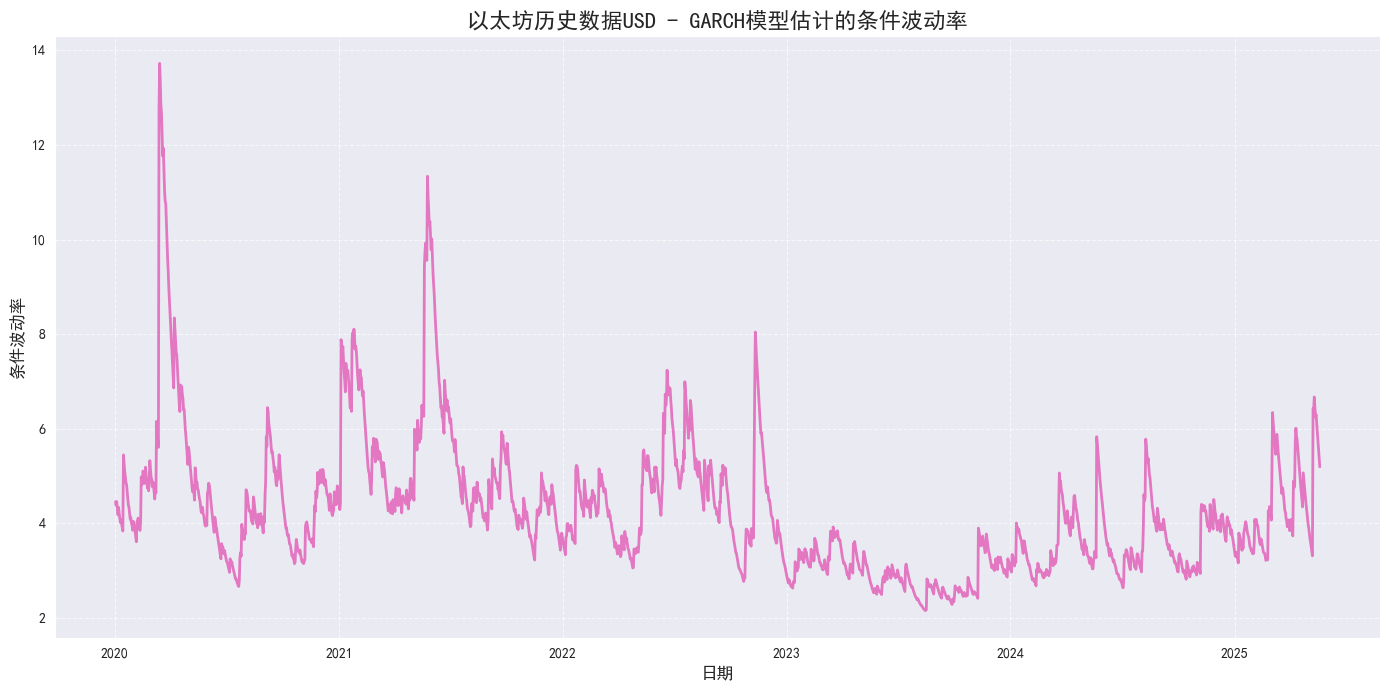


比特币历史数据USD - GARCH(1,1)模型摘要:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   日收益率   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5053.93
Distribution:                  Normal   AIC:                           10115.9
Method:            Maximum Likelihood   BIC:                           10138.2
                                        No. Observations:                 1966
Date:                Sun, Jun 08 2025   Df Residuals:                     1965
Time:                        16:22:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2337  6.711e-02      3.

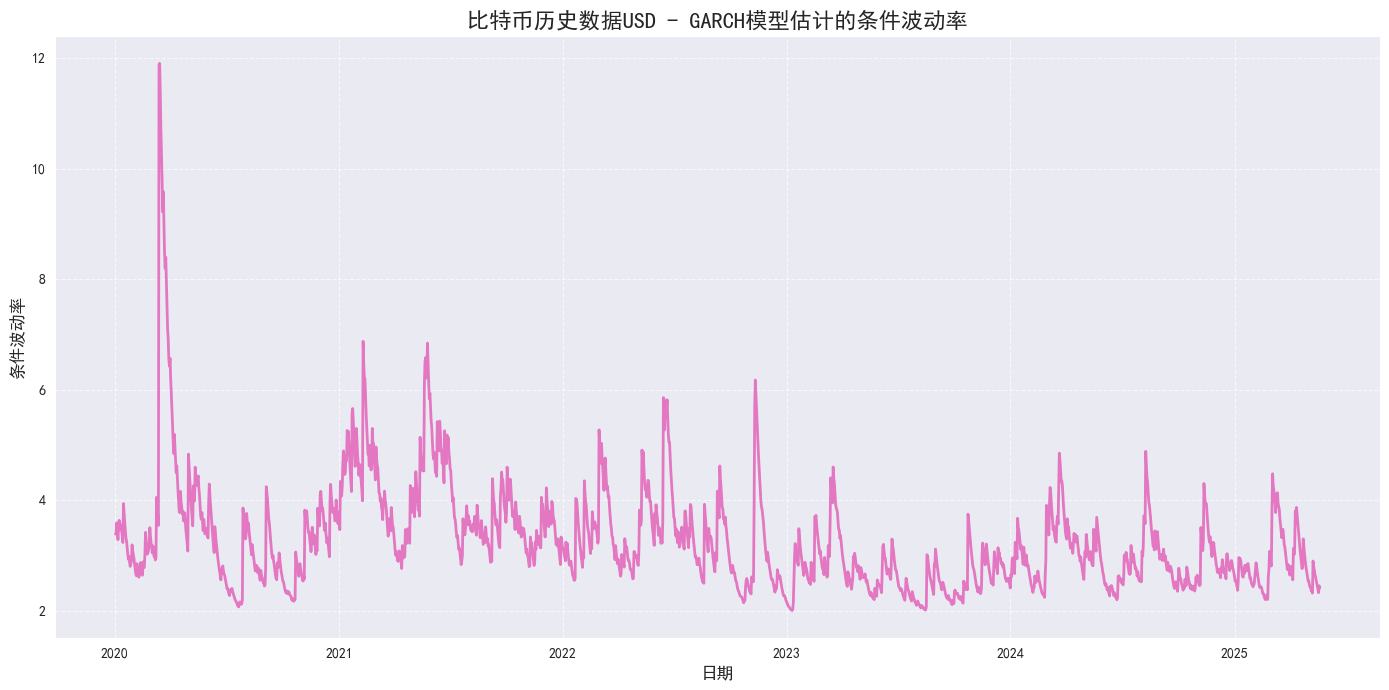


BTC_EUR Kraken 历史数据 - GARCH(1,1)模型摘要:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   日收益率   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5012.74
Distribution:                  Normal   AIC:                           10033.5
Method:            Maximum Likelihood   BIC:                           10055.8
                                        No. Observations:                 1966
Date:                Sun, Jun 08 2025   Df Residuals:                     1965
Time:                        16:22:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2214  6.

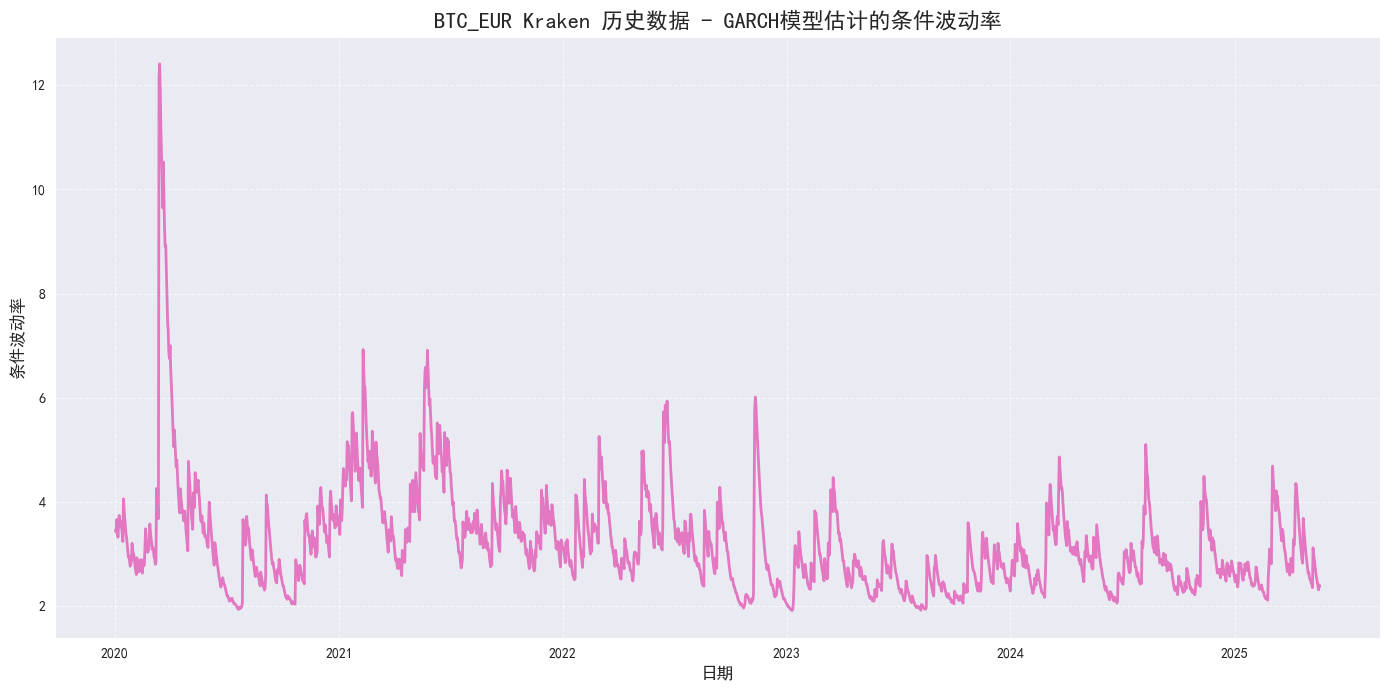


ETH_EUR Kraken 历史数据 - GARCH(1,1)模型摘要:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   日收益率   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5514.15
Distribution:                  Normal   AIC:                           11036.3
Method:            Maximum Likelihood   BIC:                           11058.6
                                        No. Observations:                 1965
Date:                Sun, Jun 08 2025   Df Residuals:                     1964
Time:                        16:22:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2339  8.

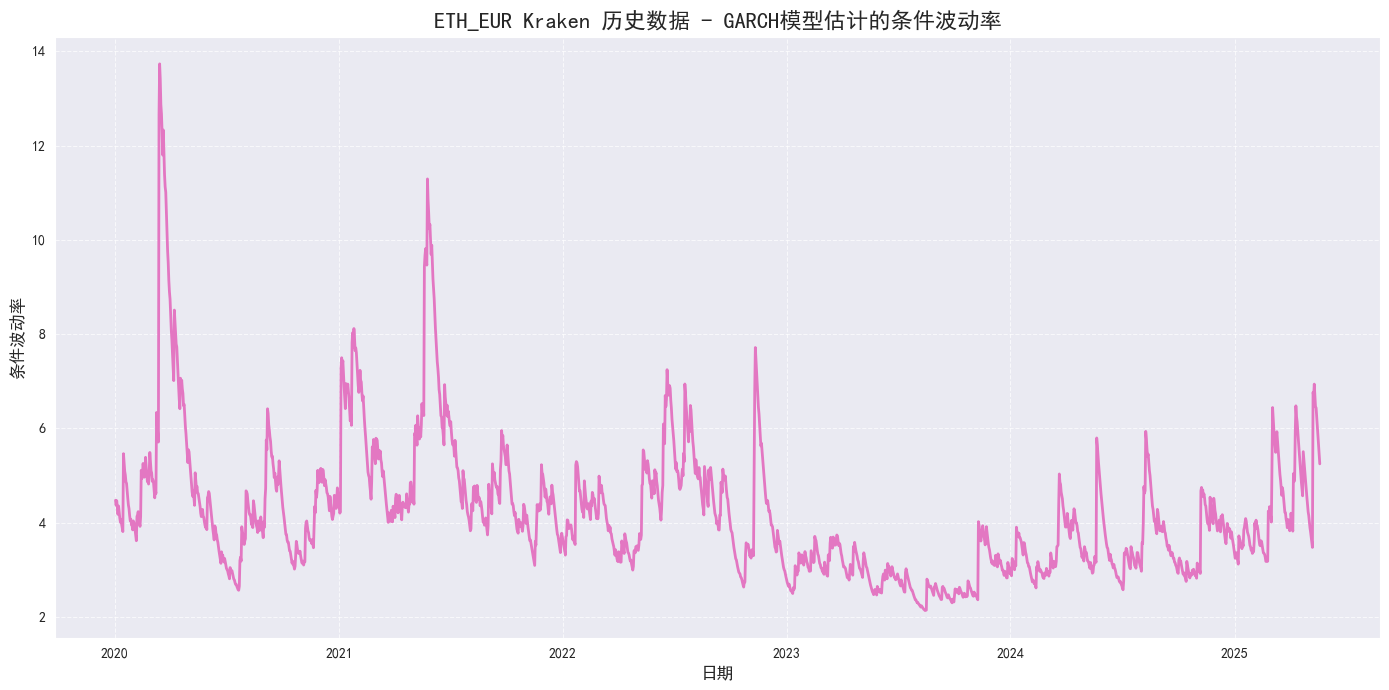

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import warnings

# 忽略警告信息，避免运行时出现大量警告干扰
warnings.filterwarnings('ignore')

# 设置可视化风格和字体配置，确保中文显示正常
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 8)  # 设置默认图表大小
plt.rcParams['axes.labelsize'] = 12  # 轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 图表标题字体大小
plt.rcParams['xtick.labelsize'] = 10  # X轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 10  # Y轴刻度标签大小

# 定义列名映射字典，将英文列名转换为中文
column_mapping = {
    'Date': '日期',
    'Close': '收盘',
    'Open': '开盘',
    'High': '高',
    'Low': '低',
    'Volume': '交易量',
    'Change': '涨跌幅'
}

def preprocess_data(data):
    """数据预处理函数，包括列名转换、数据类型转换和缺失值处理"""
    # 重命名列
    data.columns = data.columns.str.strip()  # 去除列名前后空格
    data = data.rename(columns=column_mapping)
    
    # 转换日期格式为 datetime 类型
    data['日期'] = pd.to_datetime(data['日期'], errors='coerce')
    
    # 将价格列转换为数值类型，去除可能存在的逗号分隔符
    for col in ['收盘', '开盘', '高', '低']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')
    
    # 处理交易量格式 (如 "914.76K" 转换为 914760)
    if '交易量' in data.columns:
        def convert_volume(x):
            if isinstance(x, str):
                if 'K' in x:
                    return float(x.replace('K', '')) * 1000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                else:
                    return float(x)
            return x
        
        data['交易量'] = data['交易量'].apply(convert_volume)
    
    # 处理涨跌幅，转换为小数形式
    if '涨跌幅' in data.columns:
        data['涨跌幅'] = data['涨跌幅'].str.replace('%', '').astype(float) / 100
    
    # 按日期排序并设置为索引
    data = data.sort_values('日期').set_index('日期')
    
    # 填充缺失值，使用前向填充和后向填充
    data = data.ffill().bfill()
    
    # 添加技术指标：均线和收益率
    if '收盘' in data.columns:
        data['5日均线'] = data['收盘'].rolling(window=5).mean()
        data['20日均线'] = data['收盘'].rolling(window=20).mean()
        data['50日均线'] = data['收盘'].rolling(window=50).mean()
        data['日收益率'] = data['收盘'].pct_change()
        data['波动率'] = data['日收益率'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    
    return data  # 返回预处理后的数据

def garch_model_analysis(data, title):
    """使用GARCH模型分析波动率特征"""
    if '日收益率' not in data.columns or len(data) < 100:
        print("数据不足或没有收益率数据，无法进行GARCH分析")
        return
    
    returns = data['日收益率'].dropna() * 100  # 转换为百分比
    model = arch_model(returns, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')
    
    print(f"\n{title} - GARCH(1,1)模型摘要:")
    print(model_fit.summary())
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-len(model_fit.conditional_volatility):], 
             model_fit.conditional_volatility, color='#e377c2', linewidth=2)
    plt.title(f'{title} - GARCH模型估计的条件波动率', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('条件波动率', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_GARCH波动率.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model_fit  # 返回模型拟合结果

# 定义文件路径列表
file_paths = [
    'C:/Users/Lenovo/Desktop/以太坊历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/比特币历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/BTC_EUR Kraken 历史数据.csv',
    'C:/Users/Lenovo/Desktop/ETH_EUR Kraken 历史数据.csv'
]

# 对每份数据进行GARCH模型分析
for file_path in file_paths:
    try:
        # 加载数据
        data = pd.read_csv(file_path)
        title = file_path.split('/')[-1].split('.')[0]
        data = preprocess_data(data)
        
        # 运行GARCH模型分析
        garch_model_analysis(data, title)
    except Exception as e:
        print(f"分析 {file_path} 时出错: {str(e)}")

In [ ]:
#4. 因果关系检验

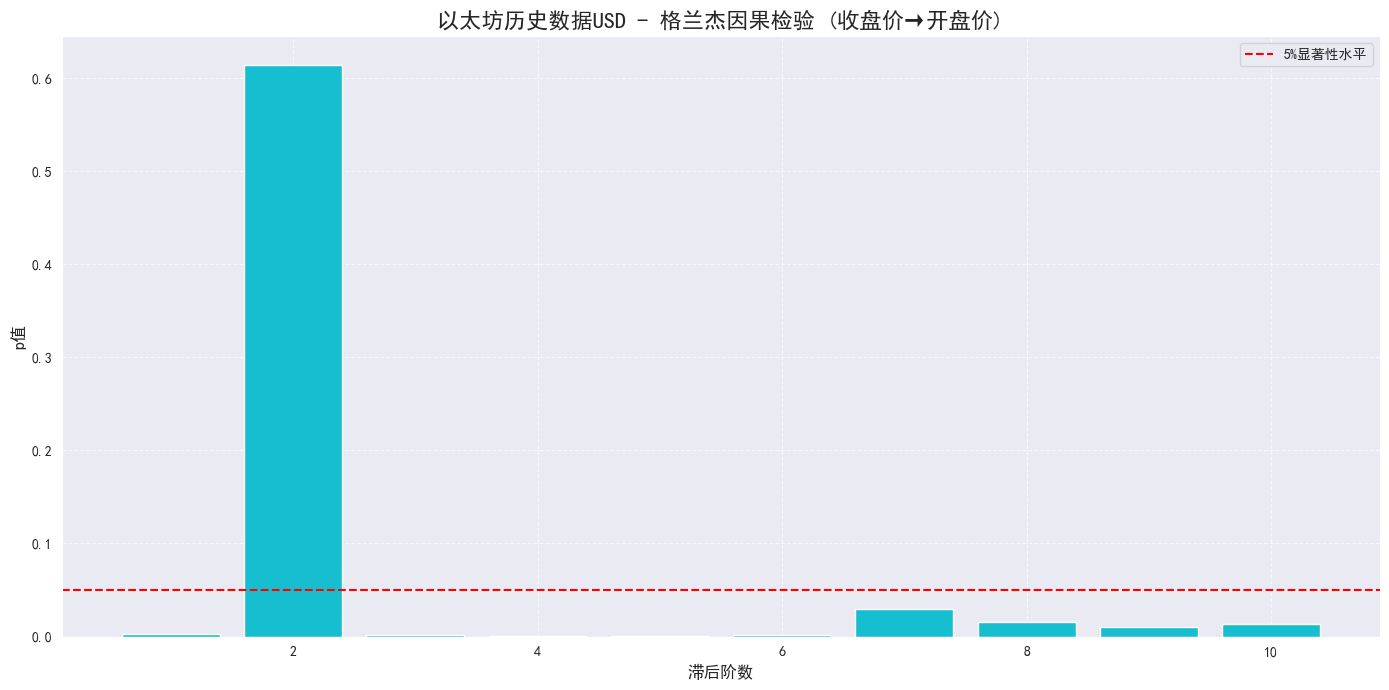


以太坊历史数据USD - 格兰杰因果检验结果 (收盘价→开盘价):
滞后 1 阶: p值 = 0.0024 ***
滞后 2 阶: p值 = 0.6144 
滞后 3 阶: p值 = 0.0014 ***
滞后 4 阶: p值 = 0.0006 ***
滞后 5 阶: p值 = 0.0006 ***
滞后 6 阶: p值 = 0.0013 ***
滞后 7 阶: p值 = 0.0294 **
滞后 8 阶: p值 = 0.0152 **
滞后 9 阶: p值 = 0.0103 **
滞后 10 阶: p值 = 0.0133 **


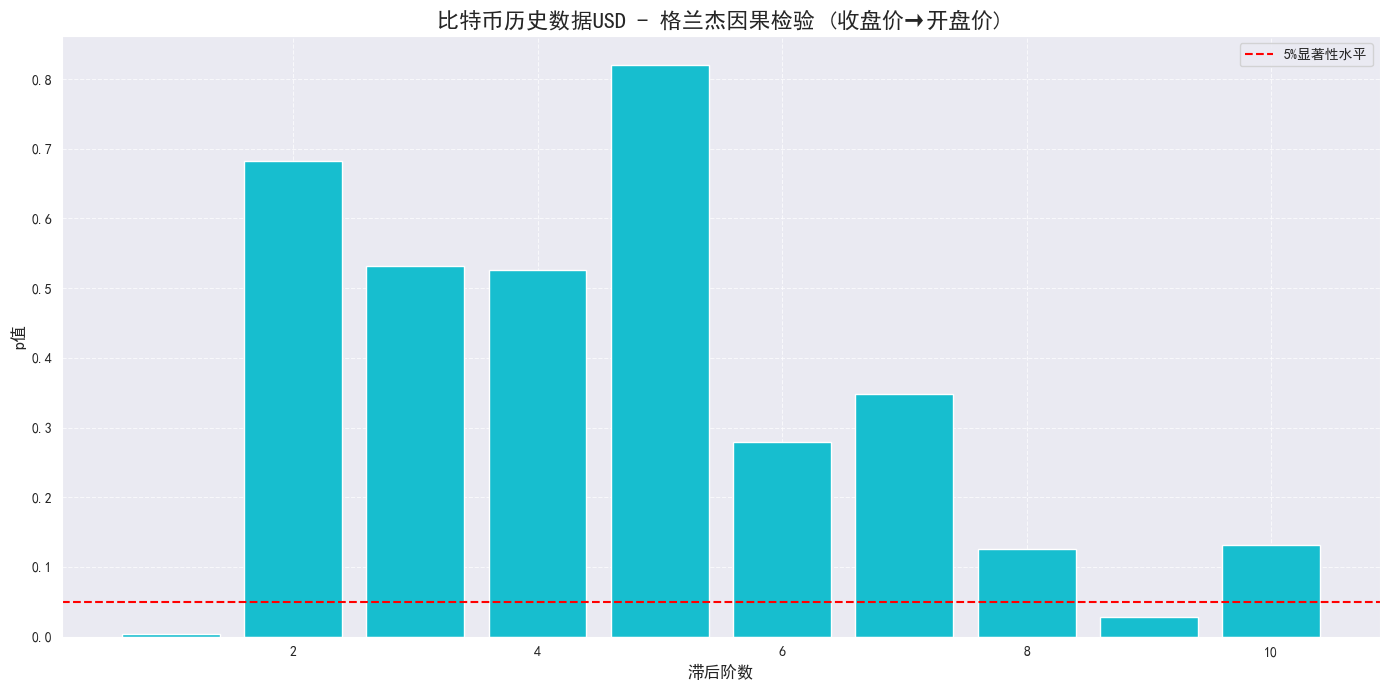


比特币历史数据USD - 格兰杰因果检验结果 (收盘价→开盘价):
滞后 1 阶: p值 = 0.0043 ***
滞后 2 阶: p值 = 0.6826 
滞后 3 阶: p值 = 0.5315 
滞后 4 阶: p值 = 0.5262 
滞后 5 阶: p值 = 0.8209 
滞后 6 阶: p值 = 0.2796 
滞后 7 阶: p值 = 0.3474 
滞后 8 阶: p值 = 0.1258 
滞后 9 阶: p值 = 0.0282 **
滞后 10 阶: p值 = 0.1319 


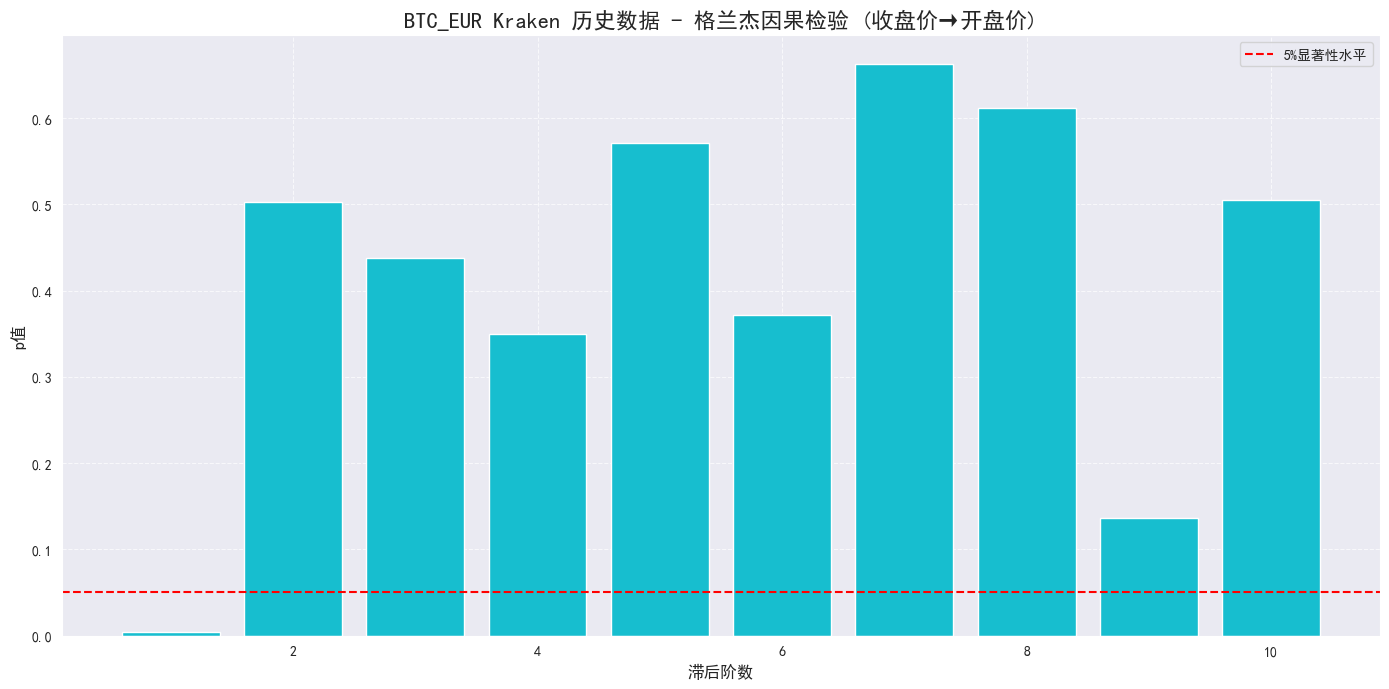


BTC_EUR Kraken 历史数据 - 格兰杰因果检验结果 (收盘价→开盘价):
滞后 1 阶: p值 = 0.0035 ***
滞后 2 阶: p值 = 0.5030 
滞后 3 阶: p值 = 0.4374 
滞后 4 阶: p值 = 0.3499 
滞后 5 阶: p值 = 0.5718 
滞后 6 阶: p值 = 0.3720 
滞后 7 阶: p值 = 0.6629 
滞后 8 阶: p值 = 0.6119 
滞后 9 阶: p值 = 0.1368 
滞后 10 阶: p值 = 0.5052 


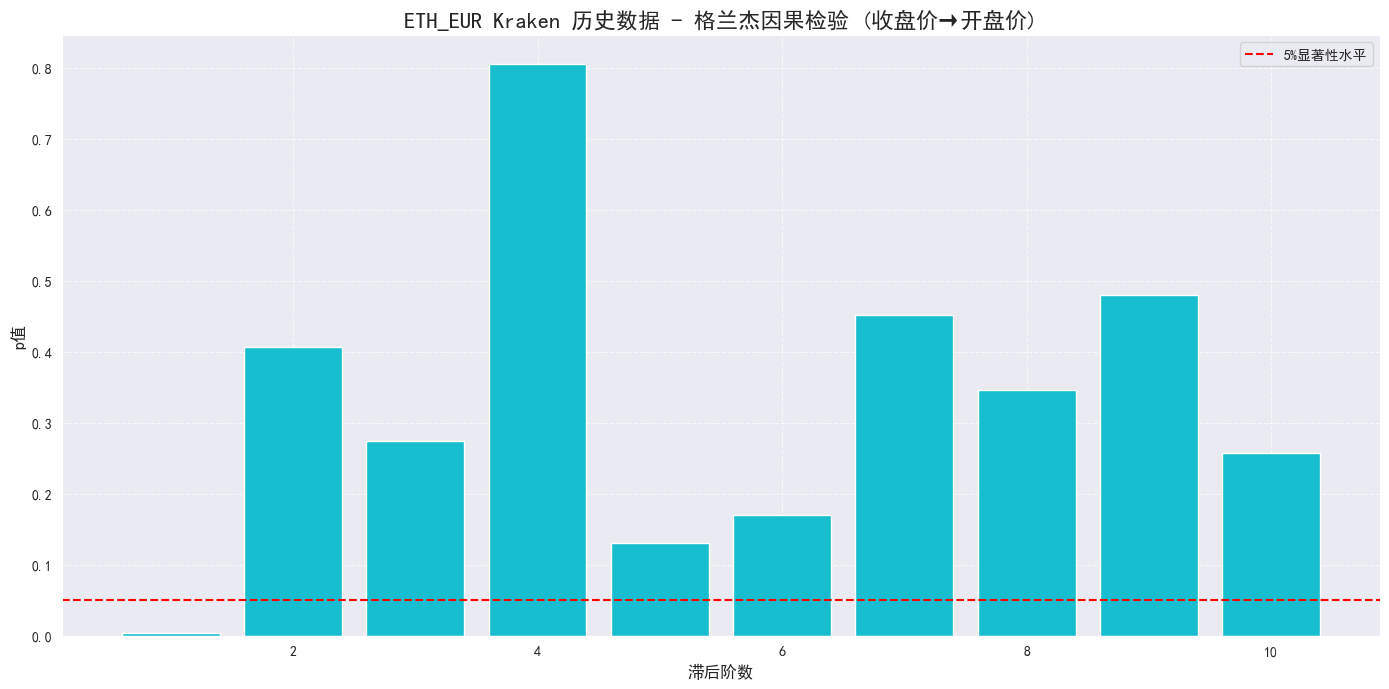


ETH_EUR Kraken 历史数据 - 格兰杰因果检验结果 (收盘价→开盘价):
滞后 1 阶: p值 = 0.0032 ***
滞后 2 阶: p值 = 0.4070 
滞后 3 阶: p值 = 0.2743 
滞后 4 阶: p值 = 0.8053 
滞后 5 阶: p值 = 0.1308 
滞后 6 阶: p值 = 0.1692 
滞后 7 阶: p值 = 0.4513 
滞后 8 阶: p值 = 0.3462 
滞后 9 阶: p值 = 0.4794 
滞后 10 阶: p值 = 0.2571 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import warnings

# 忽略警告信息，避免运行时出现大量警告干扰
warnings.filterwarnings('ignore')

# 设置可视化风格和字体配置，确保中文显示正常
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 8)  # 设置默认图表大小
plt.rcParams['axes.labelsize'] = 12  # 轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 图表标题字体大小
plt.rcParams['xtick.labelsize'] = 10  # X轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 10  # Y轴刻度标签大小

# 定义列名映射字典，将英文列名转换为中文
column_mapping = {
    'Date': '日期',
    'Close': '收盘',
    'Open': '开盘',
    'High': '高',
    'Low': '低',
    'Volume': '交易量',
    'Change': '涨跌幅'
}

def preprocess_data(data):
    """数据预处理函数，包括列名转换、数据类型转换和缺失值处理"""
    # 重命名列
    data.columns = data.columns.str.strip()  # 去除列名前后空格
    data = data.rename(columns=column_mapping)
    
    # 转换日期格式为 datetime 类型
    data['日期'] = pd.to_datetime(data['日期'], errors='coerce')
    
    # 将价格列转换为数值类型，去除可能存在的逗号分隔符
    for col in ['收盘', '开盘', '高', '低']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')
    
    # 处理交易量格式 (如 "914.76K" 转换为 914760)
    if '交易量' in data.columns:
        def convert_volume(x):
            if isinstance(x, str):
                if 'K' in x:
                    return float(x.replace('K', '')) * 1000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                else:
                    return float(x)
            return x
        
        data['交易量'] = data['交易量'].apply(convert_volume)
    
    # 处理涨跌幅，转换为小数形式
    if '涨跌幅' in data.columns:
        data['涨跌幅'] = data['涨跌幅'].str.replace('%', '').astype(float) / 100
    
    # 按日期排序并设置为索引
    data = data.sort_values('日期').set_index('日期')
    
    # 填充缺失值，使用前向填充和后向填充
    data = data.ffill().bfill()
    
    # 添加技术指标：均线和收益率
    if '收盘' in data.columns:
        data['5日均线'] = data['收盘'].rolling(window=5).mean()
        data['20日均线'] = data['收盘'].rolling(window=20).mean()
        data['50日均线'] = data['收盘'].rolling(window=50).mean()
        data['日收益率'] = data['收盘'].pct_change()
        data['波动率'] = data['日收益率'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    
    return data  # 返回预处理后的数据

def granger_causality_analysis(data, title):
    """进行格兰杰因果检验，分析变量之间的因果关系"""
    if len(data) < 50:
        print("数据长度不足，无法进行格兰杰因果检验")
        return
    
    max_lag = min(10, len(data) // 3)
    test_result = grangercausalitytests(data[['收盘', '开盘']].dropna(), maxlag=max_lag, verbose=False)
    
    p_values = [test_result[i+1][0]['ssr_chi2test'][1] for i in range(max_lag)]
    
    plt.figure(figsize=(14, 7))
    plt.bar(range(1, max_lag+1), p_values, color='#17becf')
    plt.axhline(y=0.05, color='r', linestyle='--', label='5%显著性水平')
    plt.title(f'{title} - 格兰杰因果检验 (收盘价→开盘价)', fontsize=16)
    plt.xlabel('滞后阶数', fontsize=12)
    plt.ylabel('p值', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_格兰杰因果检验.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{title} - 格兰杰因果检验结果 (收盘价→开盘价):")
    for lag in range(1, max_lag+1):
        p_value = test_result[lag][0]['ssr_chi2test'][1]
        significance = ''
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        print(f"滞后 {lag} 阶: p值 = {p_value:.4f} {significance}")

# 定义文件路径列表
file_paths = [
    'C:/Users/Lenovo/Desktop/以太坊历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/比特币历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/BTC_EUR Kraken 历史数据.csv',
    'C:/Users/Lenovo/Desktop/ETH_EUR Kraken 历史数据.csv'
]

# 对每份数据进行格兰杰因果检验
for file_path in file_paths:
    try:
        # 加载数据
        data = pd.read_csv(file_path)
        title = file_path.split('/')[-1].split('.')[0]
        data = preprocess_data(data)
        
        # 运行格兰杰因果检验
        granger_causality_analysis(data, title)
    except Exception as e:
        print(f"分析 {file_path} 时出错: {str(e)}")

In [ ]:
#5. 协整分析


以太坊历史数据USD - 协整检验结果:
t统计量: -10.7718
p值: 0.0000


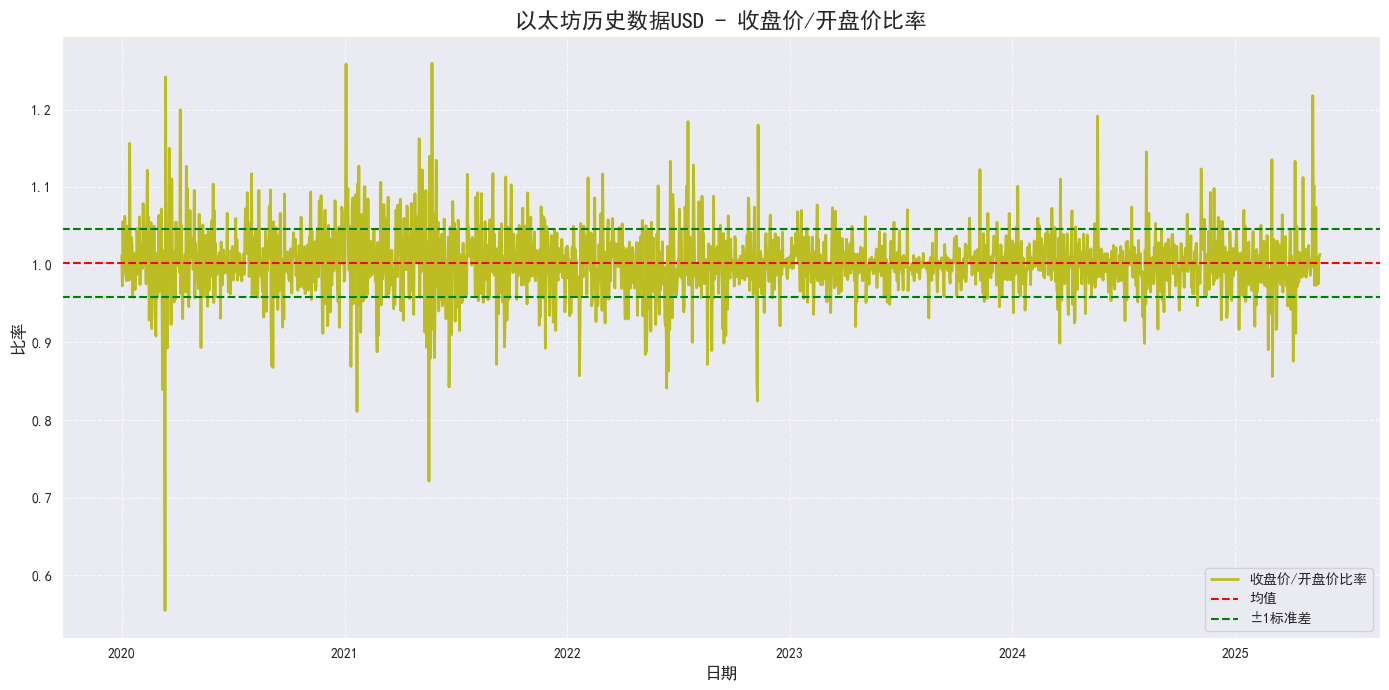


比特币历史数据USD - 协整检验结果:
t统计量: -11.0800
p值: 0.0000


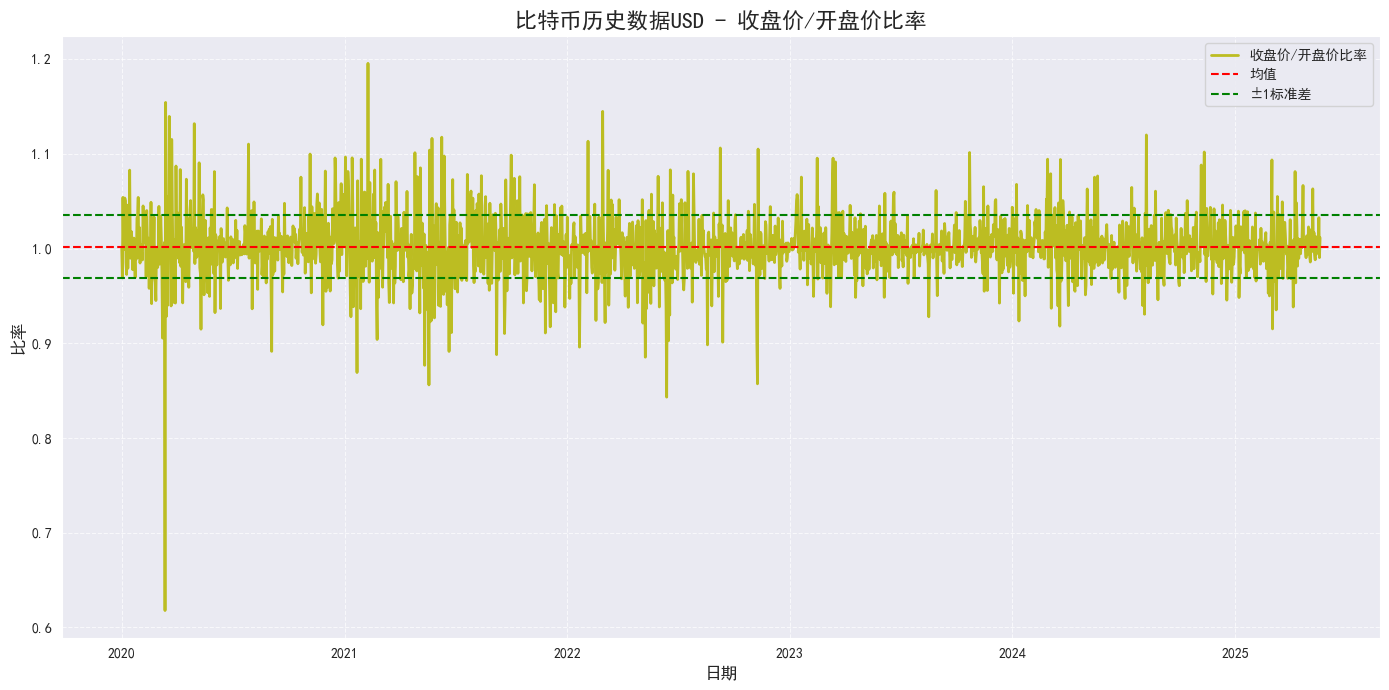


BTC_EUR Kraken 历史数据 - 协整检验结果:
t统计量: -7.8144
p值: 0.0000


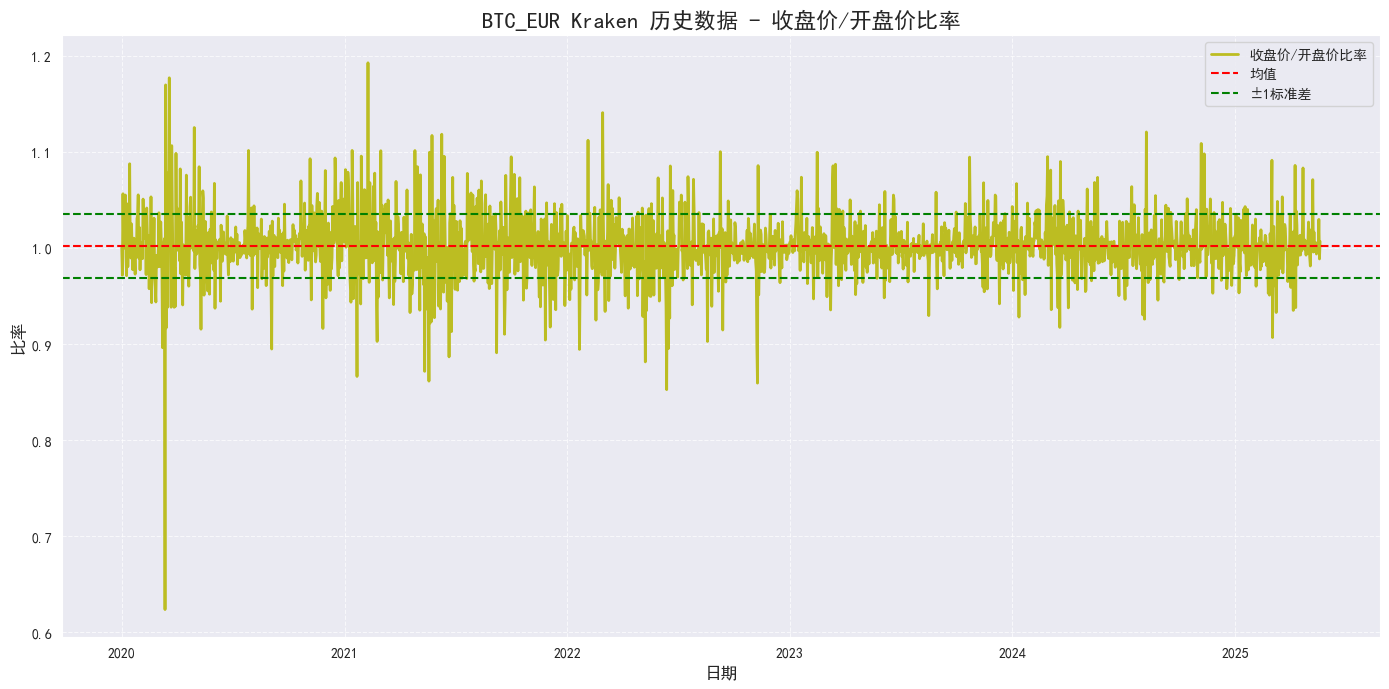


ETH_EUR Kraken 历史数据 - 协整检验结果:
t统计量: -10.4940
p值: 0.0000


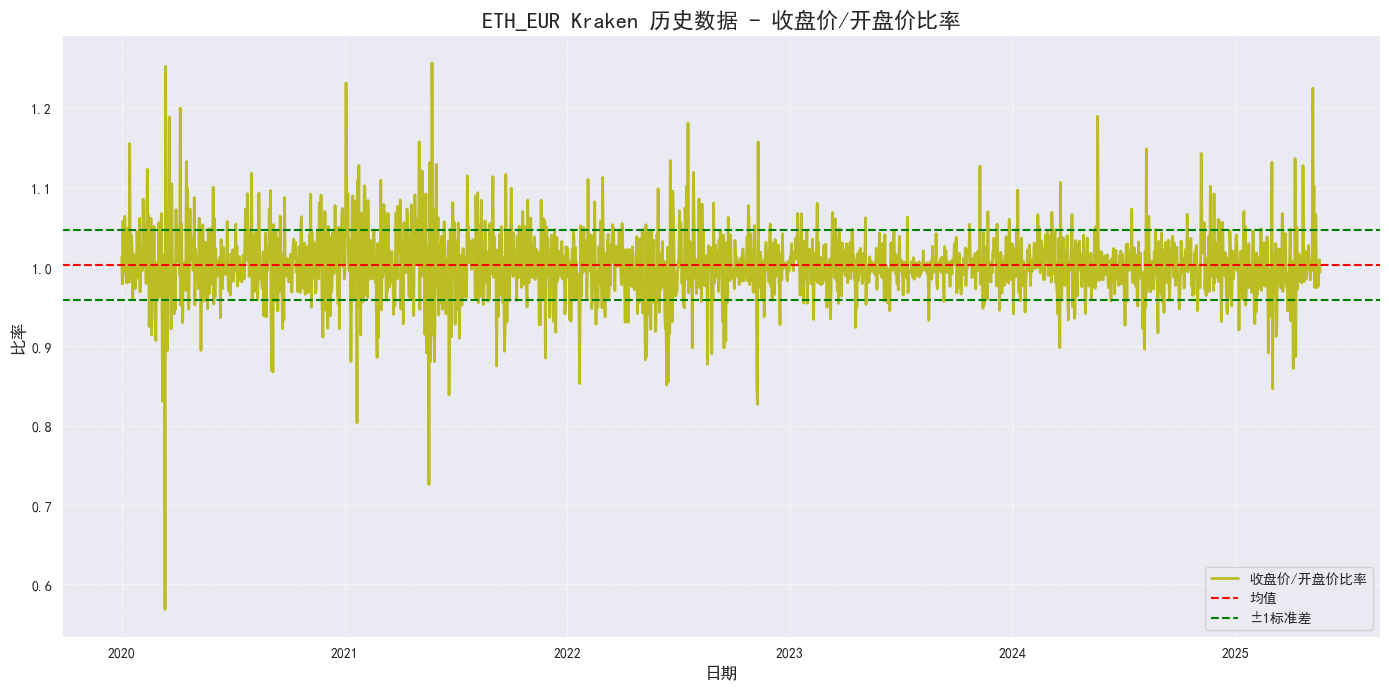

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import warnings

# 忽略警告信息，避免运行时出现大量警告干扰
warnings.filterwarnings('ignore')

# 设置可视化风格和字体配置，确保中文显示正常
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 8)  # 设置默认图表大小
plt.rcParams['axes.labelsize'] = 12  # 轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 图表标题字体大小
plt.rcParams['xtick.labelsize'] = 10  # X轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 10  # Y轴刻度标签大小

# 定义列名映射字典，将英文列名转换为中文
column_mapping = {
    'Date': '日期',
    'Close': '收盘',
    'Open': '开盘',
    'High': '高',
    'Low': '低',
    'Volume': '交易量',
    'Change': '涨跌幅'
}

def preprocess_data(data):
    """数据预处理函数，包括列名转换、数据类型转换和缺失值处理"""
    # 重命名列
    data.columns = data.columns.str.strip()  # 去除列名前后空格
    data = data.rename(columns=column_mapping)
    
    # 转换日期格式为 datetime 类型
    data['日期'] = pd.to_datetime(data['日期'], errors='coerce')
    
    # 将价格列转换为数值类型，去除可能存在的逗号分隔符
    for col in ['收盘', '开盘', '高', '低']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')
    
    # 处理交易量格式 (如 "914.76K" 转换为 914760)
    if '交易量' in data.columns:
        def convert_volume(x):
            if isinstance(x, str):
                if 'K' in x:
                    return float(x.replace('K', '')) * 1000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                else:
                    return float(x)
            return x
        
        data['交易量'] = data['交易量'].apply(convert_volume)
    
    # 处理涨跌幅，转换为小数形式
    if '涨跌幅' in data.columns:
        data['涨跌幅'] = data['涨跌幅'].str.replace('%', '').astype(float) / 100
    
    # 按日期排序并设置为索引
    data = data.sort_values('日期').set_index('日期')
    
    # 填充缺失值，使用前向填充和后向填充
    data = data.ffill().bfill()
    
    # 添加技术指标：均线和收益率
    if '收盘' in data.columns:
        data['5日均线'] = data['收盘'].rolling(window=5).mean()
        data['20日均线'] = data['收盘'].rolling(window=20).mean()
        data['50日均线'] = data['收盘'].rolling(window=50).mean()
        data['日收益率'] = data['收盘'].pct_change()
        data['波动率'] = data['日收益率'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    
    return data  # 返回预处理后的数据

def cointegration_analysis(data, title):
    """进行协整分析，检验变量之间的长期均衡关系"""
    if len(data) < 50:
        print("数据长度不足，无法进行协整分析")
        return
    
    coint_result = coint(data['收盘'], data['开盘'])
    
    print(f"\n{title} - 协整检验结果:")
    print(f"t统计量: {coint_result[0]:.4f}")
    print(f"p值: {coint_result[1]:.4f}")
    
    price_ratio = data['收盘'] / data['开盘']
    
    plt.figure(figsize=(14, 7))
    plt.plot(price_ratio, label='收盘价/开盘价比率', color='#bcbd22', linewidth=2)
    plt.axhline(y=price_ratio.mean(), color='r', linestyle='--', label='均值')
    plt.axhline(y=price_ratio.mean() + price_ratio.std(), color='g', linestyle='--', label='±1标准差')
    plt.axhline(y=price_ratio.mean() - price_ratio.std(), color='g', linestyle='--')
    plt.title(f'{title} - 收盘价/开盘价比率', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('比率', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_价格比率.png', dpi=300, bbox_inches='tight')
    plt.show()

# 定义文件路径列表
file_paths = [
    'C:/Users/Lenovo/Desktop/以太坊历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/比特币历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/BTC_EUR Kraken 历史数据.csv',
    'C:/Users/Lenovo/Desktop/ETH_EUR Kraken 历史数据.csv'
]

# 对每份数据进行协整分析
for file_path in file_paths:
    try:
        # 加载数据
        data = pd.read_csv(file_path)
        title = file_path.split('/')[-1].split('.')[0]
        data = preprocess_data(data)
        
        # 运行协整分析
        cointegration_analysis(data, title)
    except Exception as e:
        print(f"分析 {file_path} 时出错: {str(e)}")

In [ ]:
# 6. 向量自回归（VAR）模型


以太坊历史数据USD - 最佳滞后阶数 (AIC): 12

以太坊历史数据USD - VAR模型摘要:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jun, 2025
Time:                     16:56:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.93301
Nobs:                     1955.00    HQIC:                   8.84279
Log likelihood:          -14090.6    FPE:                    6570.51
AIC:                      8.79034    Det(Omega_mle):         6405.64
--------------------------------------------------------------------
Results for equation 收盘
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          9.637516         4.403099            2.189           0.029
L1.收盘          0.936422         0.022755           41.153           0.000
L1.开盘         -0.036895         2.494

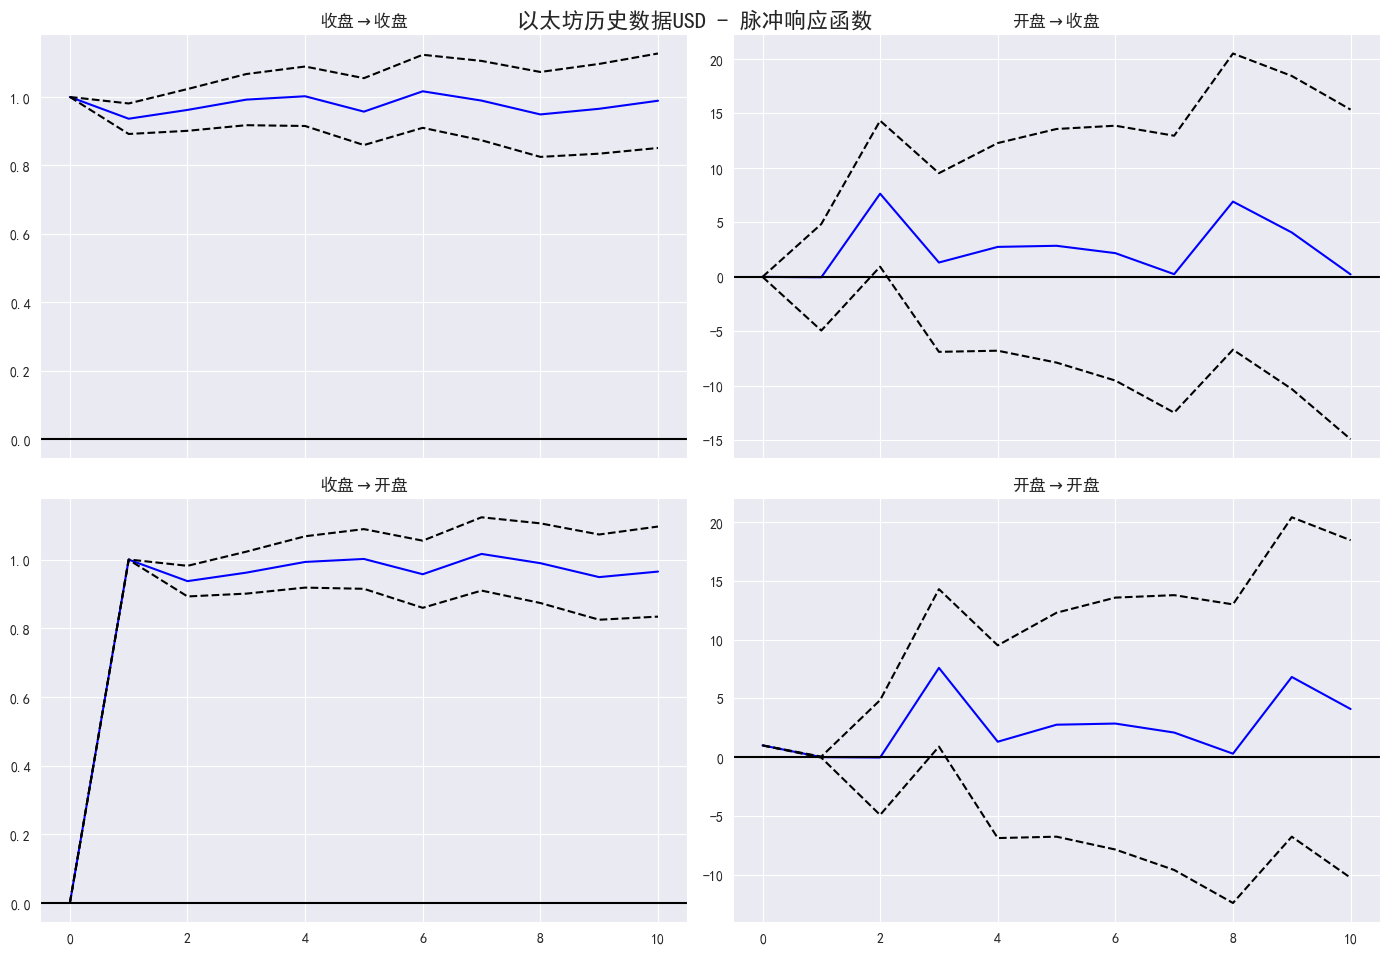

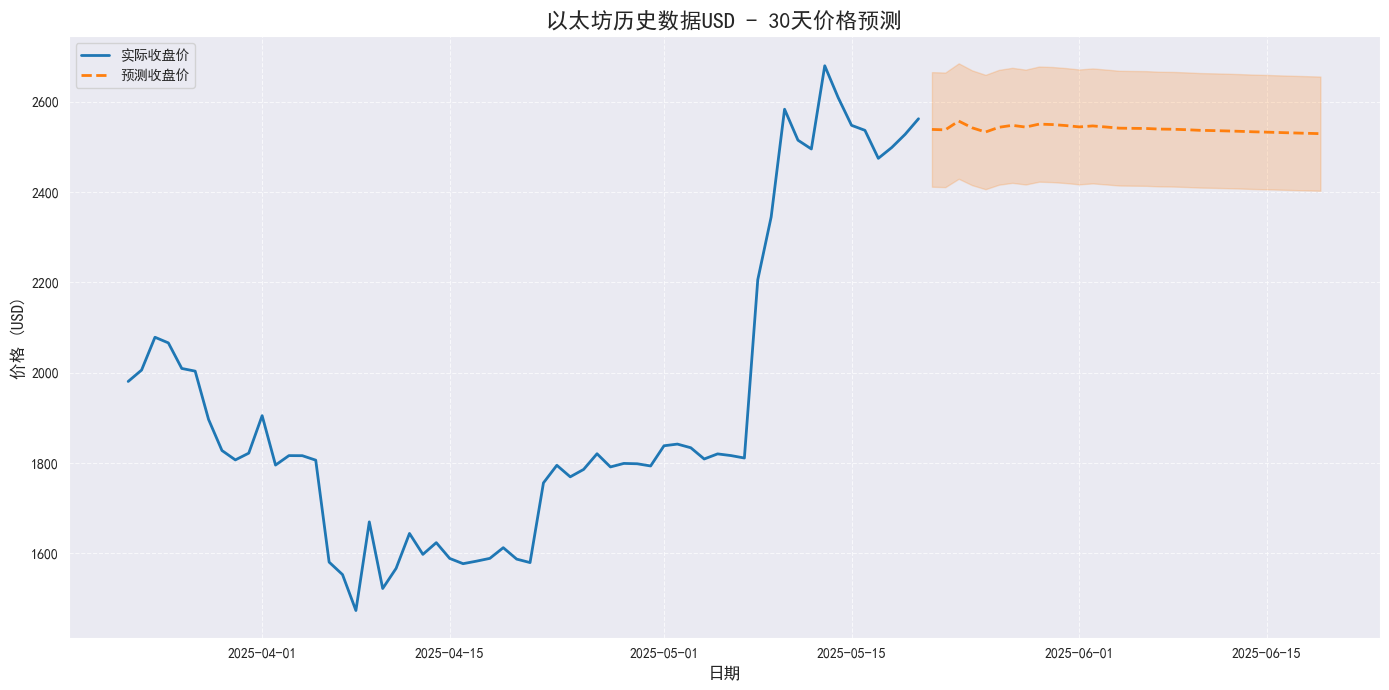


比特币历史数据USD - 最佳滞后阶数 (AIC): 1

比特币历史数据USD - VAR模型摘要:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jun, 2025
Time:                     16:56:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.0637
Nobs:                     1966.00    HQIC:                   21.0529
Log likelihood:          -26262.2    FPE:                1.38184e+09
AIC:                      21.0467    Det(Omega_mle):     1.37763e+09
--------------------------------------------------------------------
Results for equation 收盘
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        56.559251        60.286766            0.938           0.348
L1.收盘         0.935549         0.022522           41.539           0.000
L1.开盘         0.064382         0.022551   

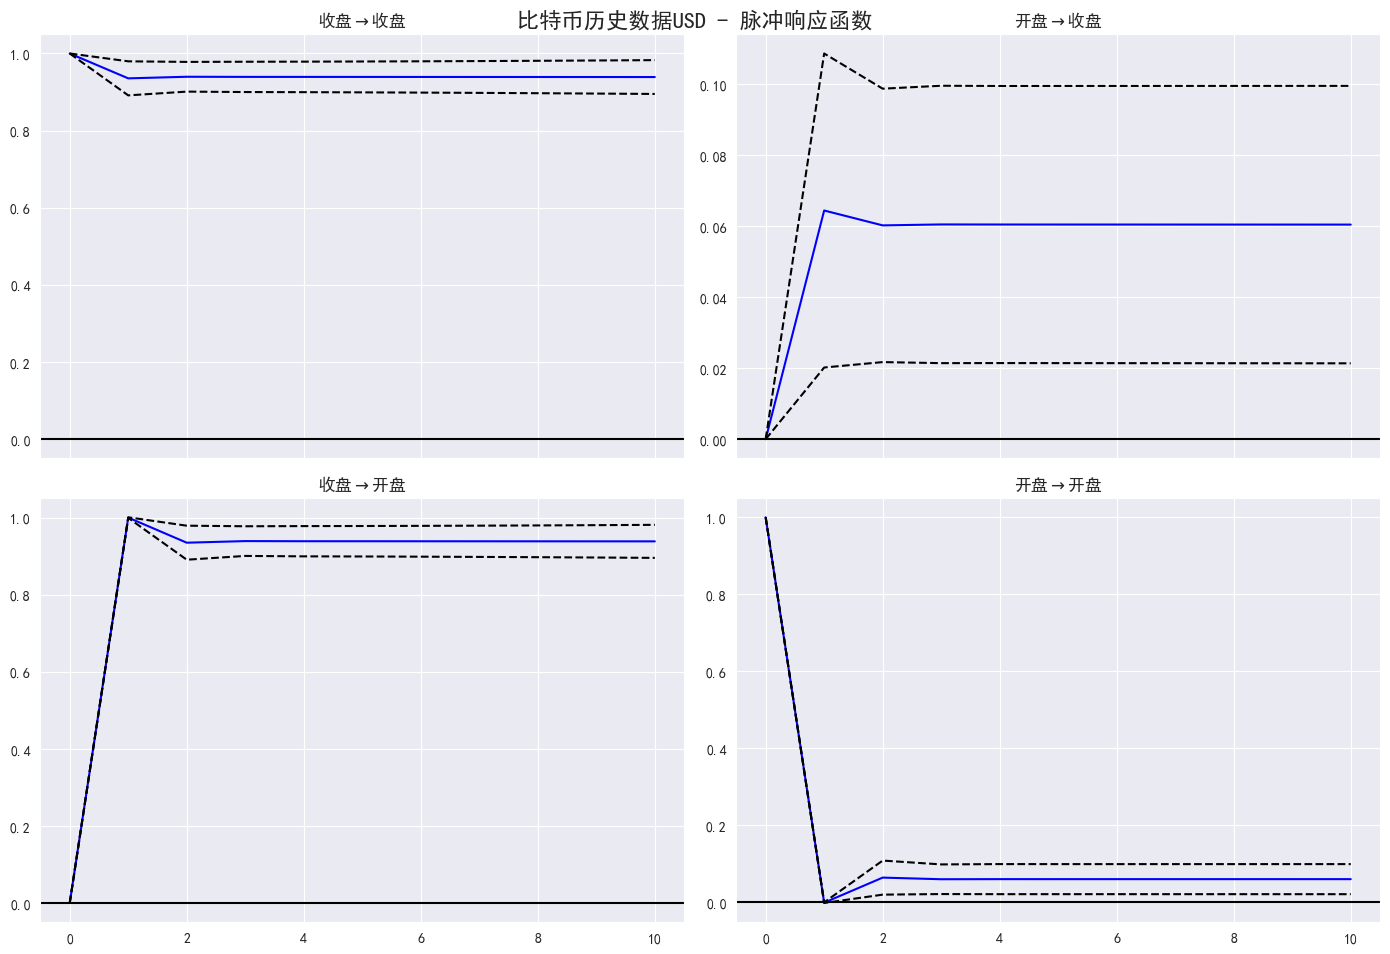

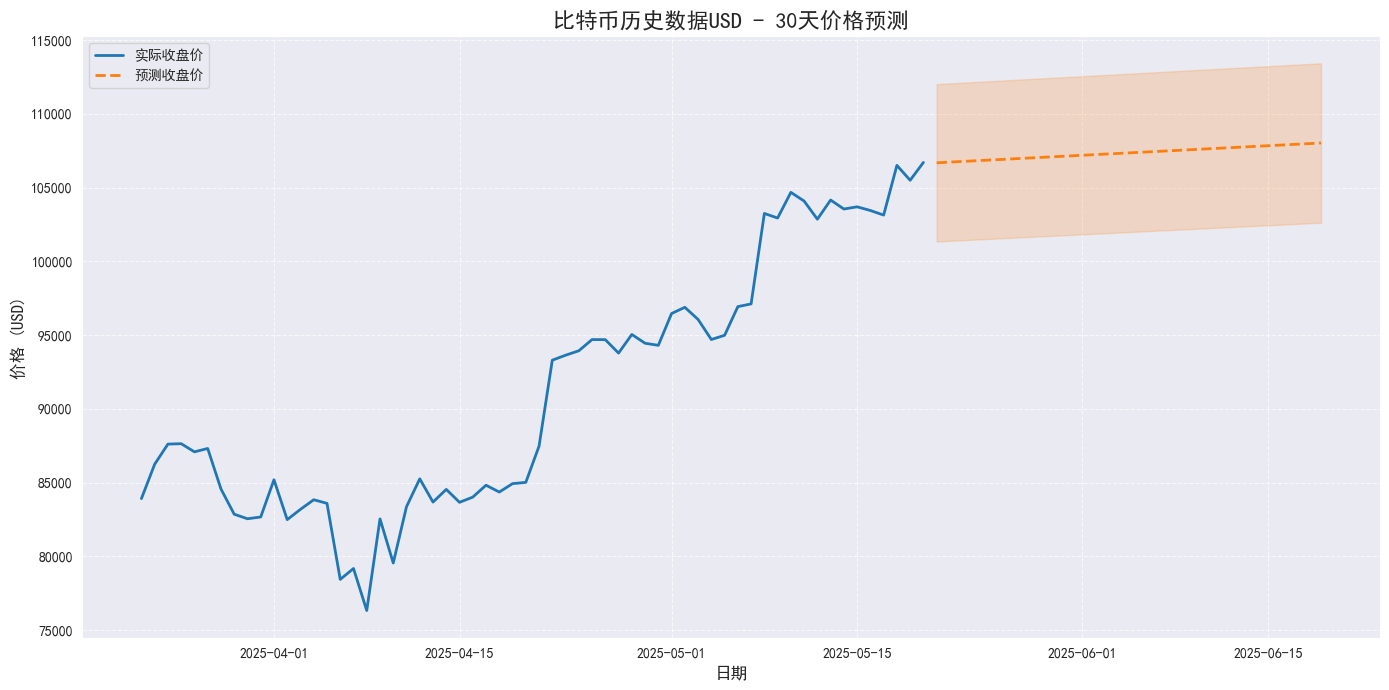


BTC_EUR Kraken 历史数据 - 最佳滞后阶数 (AIC): 1

BTC_EUR Kraken 历史数据 - VAR模型摘要:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jun, 2025
Time:                     16:56:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.7231
Nobs:                     1966.00    HQIC:                   20.7123
Log likelihood:          -25927.3    FPE:                9.82926e+08
AIC:                      20.7060    Det(Omega_mle):     9.79934e+08
--------------------------------------------------------------------
Results for equation 收盘
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        53.556164        53.145769            1.008           0.314
L1.收盘         0.934039         0.022545           41.431           0.000
L1.开盘         0.065802  

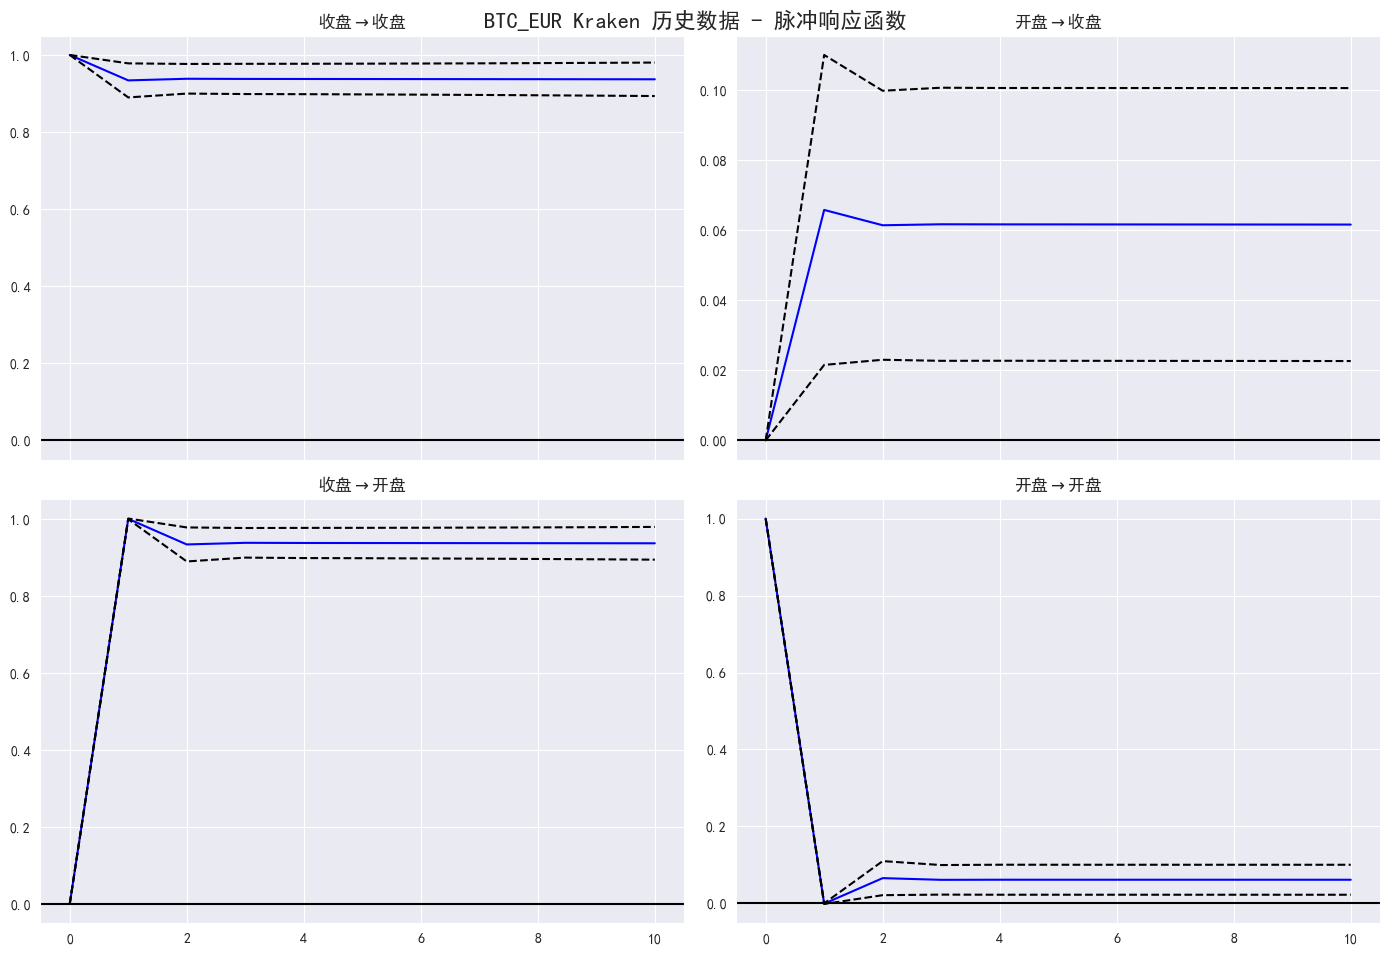

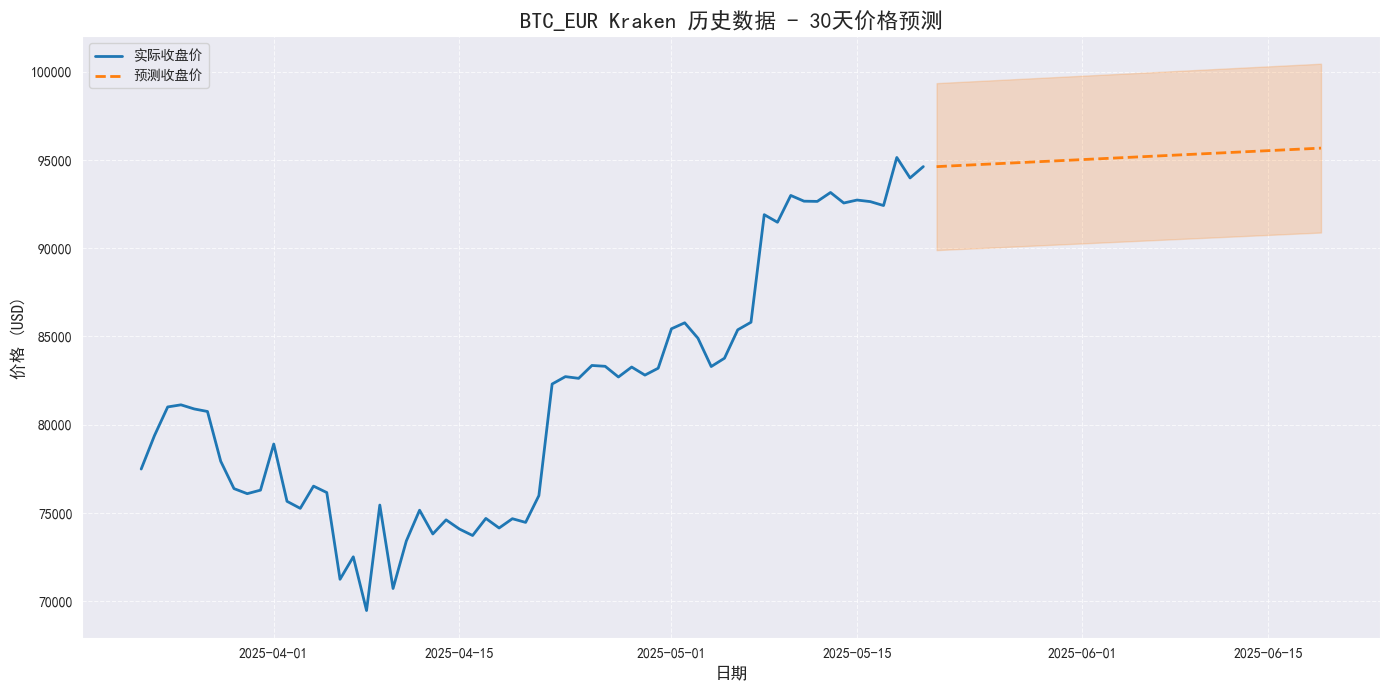


ETH_EUR Kraken 历史数据 - 最佳滞后阶数 (AIC): 5

ETH_EUR Kraken 历史数据 - VAR模型摘要:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jun, 2025
Time:                     16:56:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.3624
Nobs:                     1961.00    HQIC:                   10.3228
Log likelihood:          -15642.0    FPE:                    29726.3
AIC:                      10.2998    Det(Omega_mle):         29395.6
--------------------------------------------------------------------
Results for equation 收盘
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         8.592598         3.866758            2.222           0.026
L1.收盘         0.930468         0.022604           41.163           0.000
L1.开盘        -0.455480  

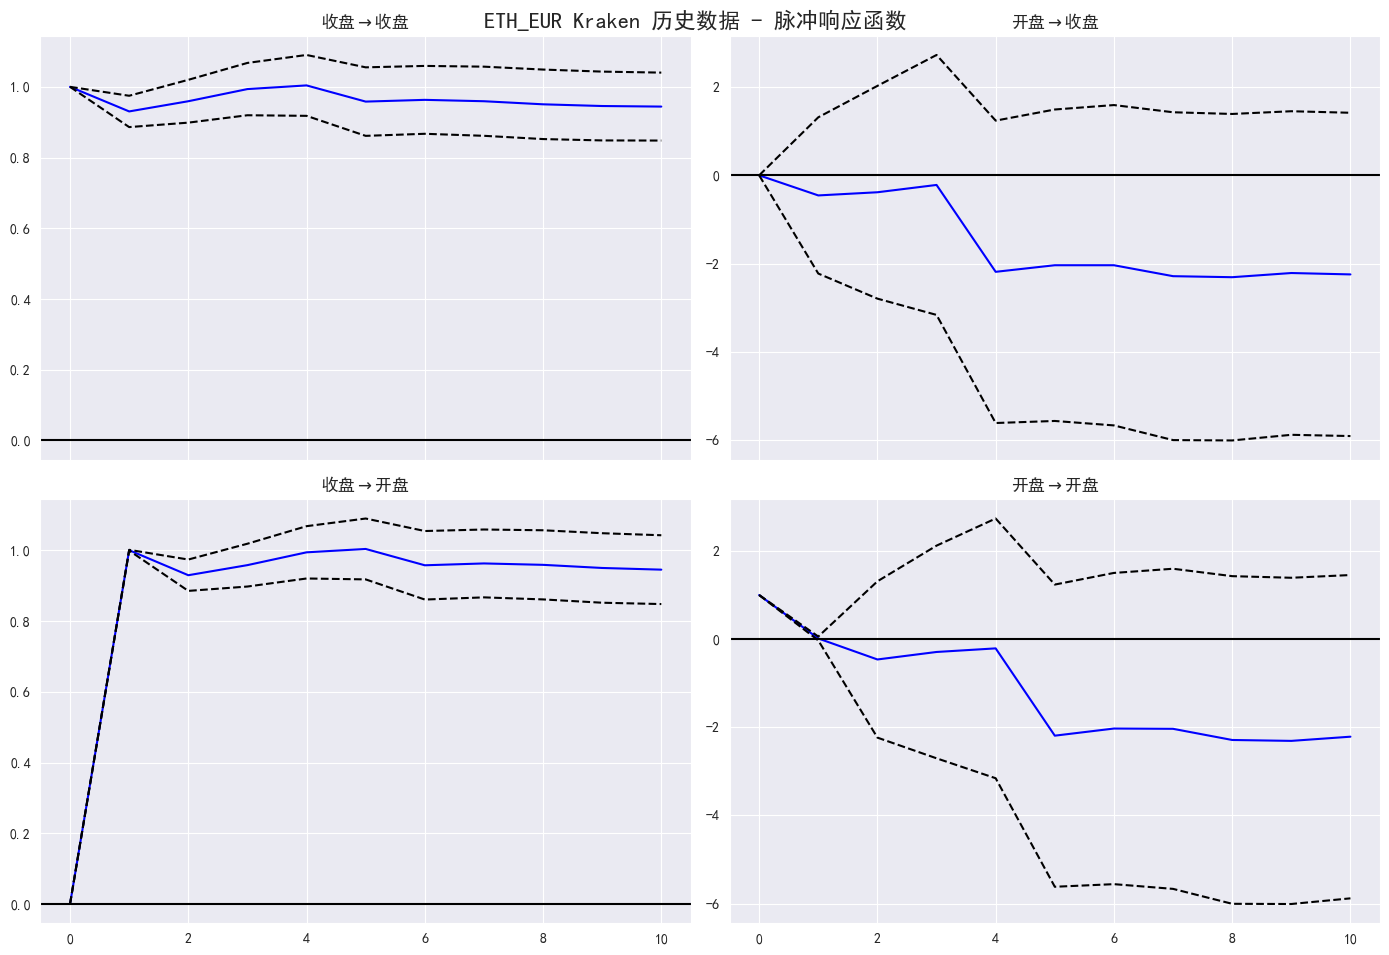

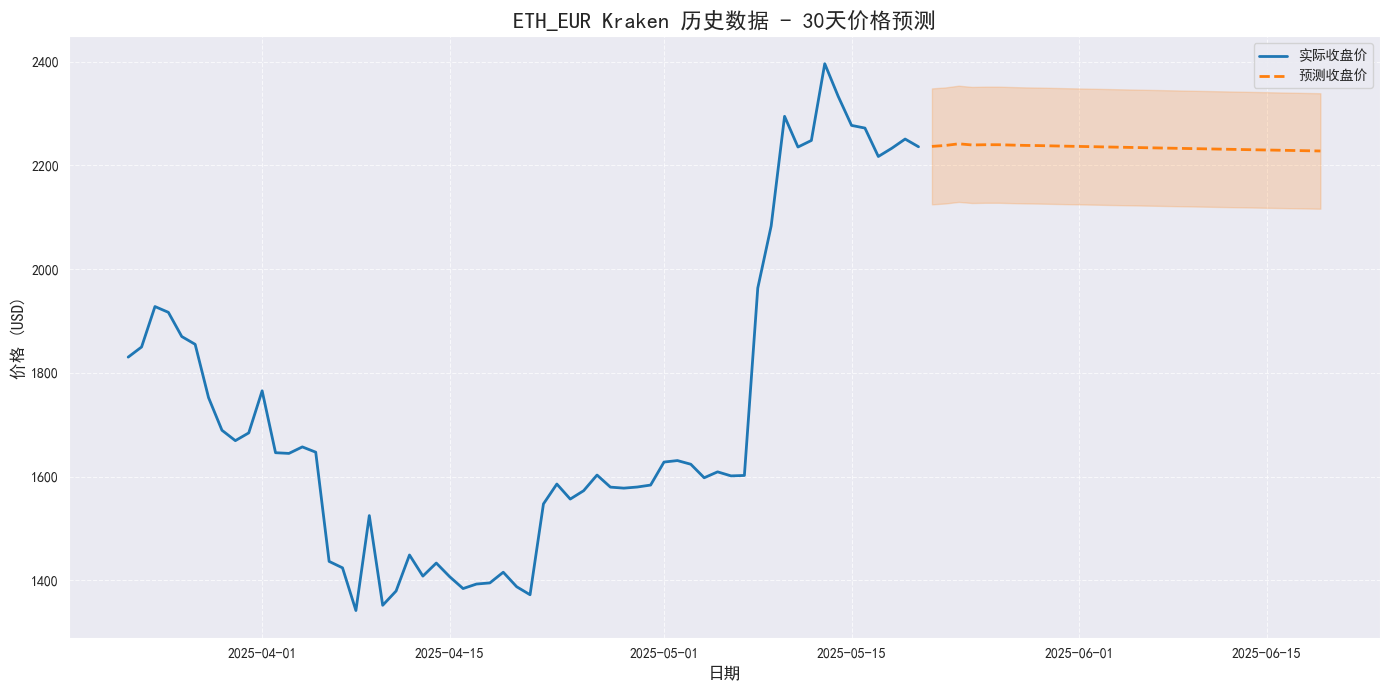

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import warnings

# 忽略警告信息，避免运行时出现大量警告干扰
warnings.filterwarnings('ignore')

# 设置可视化风格和字体配置，确保中文显示正常
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (14, 8)  # 设置默认图表大小
plt.rcParams['axes.labelsize'] = 12  # 轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 图表标题字体大小
plt.rcParams['xtick.labelsize'] = 10  # X轴刻度标签大小
plt.rcParams['ytick.labelsize'] = 10  # Y轴刻度标签大小

# 定义列名映射字典，将英文列名转换为中文
column_mapping = {
    'Date': '日期',
    'Close': '收盘',
    'Open': '开盘',
    'High': '高',
    'Low': '低',
    'Volume': '交易量',
    'Change': '涨跌幅'
}

def preprocess_data(data):
    """数据预处理函数，包括列名转换、数据类型转换和缺失值处理"""
    # 重命名列
    data.columns = data.columns.str.strip()  # 去除列名前后空格
    data = data.rename(columns=column_mapping)
    
    # 转换日期格式为 datetime 类型
    data['日期'] = pd.to_datetime(data['日期'], errors='coerce')
    
    # 将价格列转换为数值类型，去除可能存在的逗号分隔符
    for col in ['收盘', '开盘', '高', '低']:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')
    
    # 处理交易量格式 (如 "914.76K" 转换为 914760)
    if '交易量' in data.columns:
        def convert_volume(x):
            if isinstance(x, str):
                if 'K' in x:
                    return float(x.replace('K', '')) * 1000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                else:
                    return float(x)
            return x
        
        data['交易量'] = data['交易量'].apply(convert_volume)
    
    # 处理涨跌幅，转换为小数形式
    if '涨跌幅' in data.columns:
        data['涨跌幅'] = data['涨跌幅'].str.replace('%', '').astype(float) / 100
    
    # 按日期排序并设置为索引
    data = data.sort_values('日期').set_index('日期')
    
    # 填充缺失值，使用前向填充和后向填充
    data = data.ffill().bfill()
    
    # 添加技术指标：均线和收益率
    if '收盘' in data.columns:
        data['5日均线'] = data['收盘'].rolling(window=5).mean()
        data['20日均线'] = data['收盘'].rolling(window=20).mean()
        data['50日均线'] = data['收盘'].rolling(window=50).mean()
        data['日收益率'] = data['收盘'].pct_change()
        data['波动率'] = data['日收益率'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    
    return data  # 返回预处理后的数据

def var_model_analysis(data, title):
    """使用VAR模型进行多变量时间序列分析"""
    if len(data) < 100:
        print("数据长度不足，无法进行VAR模型分析")
        return
    
    var_data = data[['收盘', '开盘']].dropna()
    
    model = VAR(var_data)
    selected_order = model.select_order(maxlags=15)
    lag_order = selected_order.aic
    print(f"\n{title} - 最佳滞后阶数 (AIC): {lag_order}")
    
    var_model = model.fit(lag_order)
    print(f"\n{title} - VAR模型摘要:")
    print(var_model.summary())
    
    irf = var_model.irf(10)
    irf.plot(orth=False, figsize=(14, 10), plot_stderr=True)
    plt.suptitle(f'{title} - 脉冲响应函数', fontsize=16, y=0.95)
    
    plt.tight_layout()
    plt.savefig(f'{title}_脉冲响应.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    forecast = var_model.forecast(var_data.values[-lag_order:], steps=30)
    forecast_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['收盘预测', '开盘预测'])
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-60:], data['收盘'][-60:], label='实际收盘价', color='#1f77b4', linewidth=2)
    plt.plot(forecast_df.index, forecast_df['收盘预测'], label='预测收盘价', color='#ff7f0e', linestyle='--', linewidth=2)
    plt.fill_between(forecast_df.index, 
                     forecast_df['收盘预测'] * 0.95, 
                     forecast_df['收盘预测'] * 1.05, 
                     color='#ff7f0e', alpha=0.2)
    
    plt.title(f'{title} - 30天价格预测', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('价格 (USD)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{title}_价格预测.png', dpi=300, bbox_inches='tight')
    plt.show()

# 定义文件路径列表
file_paths = [
    'C:/Users/Lenovo/Desktop/以太坊历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/比特币历史数据USD.csv',
    'C:/Users/Lenovo/Desktop/BTC_EUR Kraken 历史数据.csv',
    'C:/Users/Lenovo/Desktop/ETH_EUR Kraken 历史数据.csv'
]

# 对每份数据进行VAR模型分析
for file_path in file_paths:
    try:
        # 加载数据
        data = pd.read_csv(file_path)
        title = file_path.split('/')[-1].split('.')[0]
        data = preprocess_data(data)
        
        # 运行VAR模型分析
        var_model_analysis(data, title)
    except Exception as e:
        print(f"分析 {file_path} 时出错: {str(e)}")